# Práctica 1. Aprendizaje Automático

Authors: Carlos Iborra Llopis (100451170), Alejandra Galán Arrospide (100451273) <br>
For additional notes and requirements: https://github.com/carlosiborra/Grupo02-Practica1-AprendizajeAutomatico

# 0. Table of contents

- [Práctica 1. Aprendizaje Automático](#práctica-1-aprendizaje-automático)
  - [0. Table of contents](#0-table-of-contents)
  - [1. Requirements](#1-requirements)
  - [2. Reading the datasets](#2-reading-the-datasets)
  - [3. Exploratory Data Analysis](#3-EDA)
  - [4. Train-Test division ](#4-Train-Test-division )
  - [5. Basic Methods](#5-basic-methods)
  - [6. Reducing Dimensionality](#6-Reducing-Dimensionality)
  - [7. Advanced methods ](#7-Advanced-methods )
  - [8. Best model](#8-Best-model)
  - [9. Final Conclusions](#6-Final-Conclusions)

# 1. Requirements


In [2]:
""" Importing necessary libraries """
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import scipy.stats as st
import scipy
import sklearn

from matplotlib.cbook import boxplot_stats as bps

### 1.1. Cleaning ../data/img/ folder
This way we avoid creating multiple images and sending the old ones to the trash.<br>
Also using this to upload cleaner commits to GitHub.


In [3]:
""" Cleaning the ../data/img/ folder """
import os
import glob

files = glob.glob("../data/img/*")
for f in files:
    if os.path.isfile(f) and f.endswith(".png"):
        os.remove(f)

files = glob.glob("../data/img/box-plot/*")
for f in files:
    if os.path.isfile(f) and f.endswith(".png"):
        os.remove(f)

---
# 2. Reading the datasets
Reading the datasets from the bz2 files, group 2.

In [4]:
""" Reading the dataset """
disp_df = pd.read_csv("../data/disp_st2ns1.txt.bz2", compression="bz2", index_col=0)
comp_df = pd.read_csv("../data/comp_st2ns1.txt.bz2", compression="bz2", index_col=0)

---
# 3. EDA

**Key Concepts of Exploratory Data Analysis**

- **2 types of Data Analysis**
  - Confirmatory Data Analysis
  - Exploratory Data Analysis
- **4 Objectives of EDA**
  - Discover Patterns
  - Spot Anomalies
  - Frame Hypothesis
  - Check Assumptions
- **2 methods for exploration**
  - Univariate Analysis
  - Bivariate Analysis
- **Stuff done during EDA**
  - Trends
  - Distribution
  - Mean
  - Median
  - Outlier
  - Spread measurement (SD)
  - Correlations
  - Hypothesis testing
  - Visual Exploration


## 3.0. Dataset preparation

To conduct exploratory data analysis (EDA) on our real data, we need to prepare the data first. Therefore, we have decided to separate the data into training and test sets at an early stage to avoid data leakage, which could result in an overly optimistic evaluation of the model, among other consequences. This separation will be done by dividing the data prematurely into training and test sets since potential data leakage can occur from the usage of the test partition, especially when including the result variable.

It is important to note that this step is necessary because all the information obtained in this section will be used to make decisions such as dimensionality reduction. Furthermore, this approach makes the evaluation more realistic and rigorous since the test set is not used until the end of the process.




In [5]:
""" Train Test Split (time series) """

# * Make a copy of the dataframe (as Padas dataframe is mutable, therefore uses a reference)
disp_df_copy = disp_df.copy()

# print(disp_df)
# print(disp_df_copy)

# Now we make the train_x, train_y, test_x, test_y splits taking into account the time series
# Note: the time series is ordered by date, therefore we need to split the data in a way that the train data is before the test data
# Note: the 10 first years are used for training and the last two years for testing
# Note: this is done because if not, we will be predicting the past from the future, which leads to errors and overfitting (data leakage) in the model

# * Calculate the number of rows for training and testing
num_rows = disp_df_copy.shape[0]
num_train_rows = int(
    num_rows * 10 / 12
)  # 10 first years for training, 2 last years for testing

# * Split the data into train and test dataframes (using iloc instead of train_test_split as it picks random rows)
train_df = disp_df_copy.iloc[
    :num_train_rows, :
]  # train contains the first 10 years of rows
test_df = disp_df_copy.iloc[
    num_train_rows:, :
]  # test contains the last 2 years of rows

# Print the number of rows for each dataframe
print(f"Number of rows for training (EDA): {train_df.shape[0]}")
print(f"Number of rows for testing: {test_df.shape[0]}")


# ! We maintain the original dataframe for later use (as we will divide it into train and test dataframes below)
# ! For the EDA, we will use the train_df dataframe (with the outpout variable).

Number of rows for training (EDA): 3650
Number of rows for testing: 730


## 3.1. Dataset description

- **apcp_sfc**: 3-Hour accumulated precipitation at the surface (kg·m⁽⁻²⁾)
- **dlwrf_sfc**: Downward long-wave radiative flux average at the surface (W·m⁽⁻²⁾)
- **dswrf_sfc**: Downward short-wave radiative flux average at the surface (W·m⁽⁻²⁾)
- **pres_msl**: Air pressure at mean sea level (Pa)
- **pwat_eatm**: Precipitable Water over the entire depth of the atmosphere (kg·m⁽⁻²⁾)
- **spfh_2m**: Specific Humidity at 2 m above ground (kg·kg⁽⁻¹⁾)
- **tcdc_eatm**: Total cloud cover over the entire depth of the atmosphere (%)
- **tcolc_eatm**: Total column-integrated condensate over the entire atmos. (kg·m⁽⁻²⁾)
- **tmax_2m**: Maximum Temperature over the past 3 hours at 2 m above the ground (K)
- **tmin_2m**: Mininmum Temperature over the past 3 hours at 2 m above the ground (K)
- **tmp_2m**: Current temperature at 2 m above the ground (K)
- **tmp_sfc**: Temperature of the surface (K)
- **ulwrf_sfc**: Upward long-wave radiation at the surface (W·m⁽⁻²⁾)
- **ulwrf_tatm**: Upward long-wave radiation at the top of the atmosphere (W·m⁽⁻²⁾)
- **uswrf_sfc**: Upward short-wave radiation at the surface (W·m⁽⁻²⁾)


In [6]:
# Display all the columns of the dataframe
pd.set_option("display.max_columns", None)

train_df.describe()

,apcp_sf1_1,apcp_sf2_1,apcp_sf3_1,apcp_sf4_1,apcp_sf5_1,dlwrf_s1_1,dlwrf_s2_1,dlwrf_s3_1,dlwrf_s4_1,dlwrf_s5_1,dswrf_s1_1,dswrf_s2_1,dswrf_s3_1,dswrf_s4_1,dswrf_s5_1,pres_ms1_1,pres_ms2_1,pres_ms3_1,pres_ms4_1,pres_ms5_1,pwat_ea1_1,pwat_ea2_1,pwat_ea3_1,pwat_ea4_1,pwat_ea5_1,spfh_2m1_1,spfh_2m2_1,spfh_2m3_1,spfh_2m4_1,spfh_2m5_1,tcdc_ea1_1,tcdc_ea2_1,tcdc_ea3_1,tcdc_ea4_1,tcdc_ea5_1,tcolc_e1_1,tcolc_e2_1,tcolc_e3_1,tcolc_e4_1,tcolc_e5_1,tmax_2m1_1,tmax_2m2_1,tmax_2m3_1,tmax_2m4_1,tmax_2m5_1,tmin_2m1_1,tmin_2m2_1,tmin_2m3_1,tmin_2m4_1,tmin_2m5_1,tmp_2m_1_1,tmp_2m_2_1,tmp_2m_3_1,tmp_2m_4_1,tmp_2m_5_1,tmp_sfc1_1,tmp_sfc2_1,tmp_sfc3_1,tmp_sfc4_1,tmp_sfc5_1,ulwrf_s1_1,ulwrf_s2_1,ulwrf_s3_1,ulwrf_s4_1,ulwrf_s5_1,ulwrf_t1_1,ulwrf_t2_1,ulwrf_t3_1,ulwrf_t4_1,ulwrf_t5_1,uswrf_s1_1,uswrf_s2_1,uswrf_s3_1,uswrf_s4_1,uswrf_s5_1,salida
count,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3.650000e+03
mean,0.610222,0.251049,0.479367,0.279969,0.525625,316.590458,316.996492,324.225574,343.169304,342.582550,0.074371,163.928966,376.718929,686.534869,508.429988,101718.580471,101774.517076,101743.013770,101538.253073,101499.397514,21.394485,21.536129,22.127195,22.595594,22.384870,0.007844,0.008848,0.009356,0.009473,0.009918,0.069240,0.067845,0.064862,0.065706,0.062366,0.069539,0.068172,0.065166,0.066036,0.062748,286.950030,288.292227,292.803749,294.483694,294.542492,284.595935,284.638684,284.617400,292.733513,291.084714,284.846286,288.227387,292.740802,294.299550,291.301035,284.094056,289.230769,295.533258,295.904819,290.366407,375.991521,381.989673,400.742449,439.104661,431.318749,247.736467,247.626828,251.950057,262.207928,261.074238,0.078107,38.716712,76.394795,127.098207,99.476613,1.638200e+07
std,2.245850,0.994112,1.756408,1.120933,1.931408,56.119896,58.129352,58.941747,61.150202,61.027007,0.305126,112.645372,159.486316,227.642854,193.753483,725.206610,731.500969,720.701217,699.477989,715.361146,12.256253,12.358856,12.583364,12.633154,12.401121,0.004398,0.005039,0.005175,0.005097,0.005456,0.167104,0.169653,0.171287,0.172516,0.166113,0.166989,0.169522,0.171172,0.172385,0.165958,8.925065,9.743169,9.898253,9.789117,9.776615,8.735982,8.862301,8.866503,9.950300,10.099684,8.722593,9.795209,9.944761,9.795537,10.083859,8.861650,9.756852,9.148308,9.317363,10.462108,46.586515,49.914820,50.766618,53.159310,54.417631,36.270918,36.289003,35.798277,38.698726,38.427066,0.258752,26.010130,30.743175,40.765618,35.505727,8.059674e+06
min,0.000000,0.000000,0.000000,0.000000,0.000000,158.971770,160.032903,165.524543,183.671312,186.342961,0.000000,0.000000,20.000000,30.000000,20.000000,99316.970881,99315.887074,99327.755682,99040.100852,98830.153409,1.100000,1.314819,1.107352,1.142803,1.201246,0.000462,0.000485,0.000451,0.000478,0.000468,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,254.589220,254.937418,258.549777,260.800365,260.863475,251.941358,249.576132,249.576714,258.698331,258.171345,251.942065,254.844406,258.552646,260.795430,258.170049,250.100794,256.360800,263.634377,264.533564,256.520408,229.296161,223.985486,246.314349,278.576630,271.707606,104.671267,113.559602,118.679132,

In [7]:
train_df.shape

(3650, 76)

In [8]:
train_df.head()

,apcp_sf1_1,apcp_sf2_1,apcp_sf3_1,apcp_sf4_1,apcp_sf5_1,dlwrf_s1_1,dlwrf_s2_1,dlwrf_s3_1,dlwrf_s4_1,dlwrf_s5_1,dswrf_s1_1,dswrf_s2_1,dswrf_s3_1,dswrf_s4_1,dswrf_s5_1,pres_ms1_1,pres_ms2_1,pres_ms3_1,pres_ms4_1,pres_ms5_1,pwat_ea1_1,pwat_ea2_1,pwat_ea3_1,pwat_ea4_1,pwat_ea5_1,spfh_2m1_1,spfh_2m2_1,spfh_2m3_1,spfh_2m4_1,spfh_2m5_1,tcdc_ea1_1,tcdc_ea2_1,tcdc_ea3_1,tcdc_ea4_1,tcdc_ea5_1,tcolc_e1_1,tcolc_e2_1,tcolc_e3_1,tcolc_e4_1,tcolc_e5_1,tmax_2m1_1,tmax_2m2_1,tmax_2m3_1,tmax_2m4_1,tmax_2m5_1,tmin_2m1_1,tmin_2m2_1,tmin_2m3_1,tmin_2m4_1,tmin_2m5_1,tmp_2m_1_1,tmp_2m_2_1,tmp_2m_3_1,tmp_2m_4_1,tmp_2m_5_1,tmp_sfc1_1,tmp_sfc2_1,tmp_sfc3_1,tmp_sfc4_1,tmp_sfc5_1,ulwrf_s1_1,ulwrf_s2_1,ulwrf_s3_1,ulwrf_s4_1,ulwrf_s5_1,ulwrf_t1_1,ulwrf_t2_1,ulwrf_t3_1,ulwrf_t4_1,ulwrf_t5_1,uswrf_s1_1,uswrf_s2_1,uswrf_s3_1,uswrf_s4_1,uswrf_s5_1,salida
V1,0.0,0.0,0.0,0.000000,0.0,268.583582,244.241641,251.174486,269.741308,268.377441,0.0,30.0,220.000000,510.000000,330.000000,101832.056108,102053.159091,102090.046165,101934.175426,101988.003551,5.879193,7.018182,8.460800,9.418182,9.727869,0.003229,0.002993,0.003775,0.003870,0.003855,0.000000,0.000000,0.000000,0.000000,0.000909,0.000818,0.000264,0.000255,0.000500,0.002218,280.789784,279.627444,285.727761,286.881681,286.885823,279.198020,278.472615,278.474720,285.799685,280.966961,279.249256,279.612202,285.742784,286.841053,280.960865,277.278370,279.250383,288.826760,288.596086,278.500078,341.122231,335.067918,354.626126,397.774053,383.281225,222.153166,252.504475,254.760271,263.342404,260.067843,0.0,10.000000,50.000000,106.636364,72.000000,11930700
V2,0.0,0.0,0.0,0.008182,0.2,251.725869,255.824126,272.163913,318.259924,307.929083,0.0,30.0,173.636364,333.636364,224.545455,101425.883523,101284.509233,101253.654830,100999.313920,101424.626420,12.534339,11.987316,12.159355,12.313590,13.469729,0.003737,0.003931,0.004015,0.003994,0.004826,0.037273,0.021818,0.101818,0.084545,0.109091,0.037155,0.021309,0.102373,0.085827,0.109336,278.822329,278.063379,283.618583,286.606684,286.643397,277.258919,276.740628,276.740628,283.687009,282.111078,277.282621,278.070390,283.604600,286.554729,282.105011,275.830009,278.269459,287.048970,287.325478,281.005252,330.159915,329.354673,347.524819,388.017767,378.773804,236.836691,233.458263,233.027276,212.652054,222.052916,0.0,8.181818,35.909091,58.181818,42.090909,9778500
V3,0.0,0.0,0.0,0.000000,0.0,219.734547,211.996022,216.405820,235.529123,239.840132,0.0,30.0,220.000000,523.636364,337.545455,102253.654119,102301.918324,102088.093750,101652.815341,101543.146307,5.726770,5.458528,5.700000,7.163636,9.536364,0.002003,0.001919,0.002107,0.002431,0.002583,0.000000,0.000000,0.007273,0.007273,0.042727,0.001427,0.001582,0.007309,0.006973,0.042127,275.400091,270.222512,275.885787,279.049513,279.381653,269.756037,269.157731,269.156439,276.041792,275.301960,269.766876,270.204285,275.880818,279.064603,275.806757,269.533059,271.690993,281.759993,282.686446,273.615503,309.639845,299.751961,317.250763,364.339136,351.496665,238.655654,232.828737,235.480750,245.177331,238.893102,0.0,10.272727,55.272727,118.454545,79.181818,9771900
V4,0.0,0.0,0.0,0.000000,0.0,253.499410,230.896544,235.857221,240.274556,237.804048,0.0,30.0,208.181818,512.727273,337.181818,102110.375710,102435.603693,102688.528409,102588.876420,102598.252841,7.889904,6.768959,6.208357,5.977267,6.411838,0.002918,0.002735,0.002771,0.002821,0.002738,0.000000,0.002727,0.005455,0.000909,0.012727,0.000473,0.004018,0.007300,0.001600,0.014882,279.396046,276.176919,276.868630,278.550368,278.572038,276.175482,273.839142,273.840535,276.942990,273.802970,276.312428,274.045715,276.877749,278.571555,273.812827,274.824765,274.466433,281.291418,281.871679,272.191753,330.310971,318.761563,329.305478,360.297788,348.618319,236.784869,241.916776,243.398572,251.473036,247.503769,0.0,8.909091,46.000000,107.090909,73.636364,6466800
V5,0.0,0.0,0.0,0.000000,0.0,234.890020,238.927051,246.850822,271.577246,275.572826,0.0,30.0,220.000000,517.272727,336.363636,101750.

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3650 entries, V1 to V3650
Data columns (total 76 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   apcp_sf1_1  3650 non-null   float64
 1   apcp_sf2_1  3650 non-null   float64
 2   apcp_sf3_1  3650 non-null   float64
 3   apcp_sf4_1  3650 non-null   float64
 4   apcp_sf5_1  3650 non-null   float64
 5   dlwrf_s1_1  3650 non-null   float64
 6   dlwrf_s2_1  3650 non-null   float64
 7   dlwrf_s3_1  3650 non-null   float64
 8   dlwrf_s4_1  3650 non-null   float64
 9   dlwrf_s5_1  3650 non-null   float64
 10  dswrf_s1_1  3650 non-null   float64
 11  dswrf_s2_1  3650 non-null   float64
 12  dswrf_s3_1  3650 non-null   float64
 13  dswrf_s4_1  3650 non-null   float64
 14  dswrf_s5_1  3650 non-null   float64
 15  pres_ms1_1  3650 non-null   float64
 16  pres_ms2_1  3650 non-null   float64
 17  pres_ms3_1  3650 non-null   float64
 18  pres_ms4_1  3650 non-null   float64
 19  pres_ms5_1  3650 non-null   fl

## 3.2. Missing values


Fist, we check the number the total number of missing values in the dataset in order to know if we have to clean the dataset or not.

In [10]:
train_df.isna().sum()

apcp_sf1_1    0
apcp_sf2_1    0
apcp_sf3_1    0
apcp_sf4_1    0
apcp_sf5_1    0
             ..
uswrf_s2_1    0
uswrf_s3_1    0
uswrf_s4_1    0
uswrf_s5_1    0
salida        0
Length: 76, dtype: int64

As we can oberve, there are no missing values in the dataset, but theres still the possibility of having missing values measured as 0's, so we will check if all those zeros make sense in the context of the dataset or not.

<AxesSubplot:>

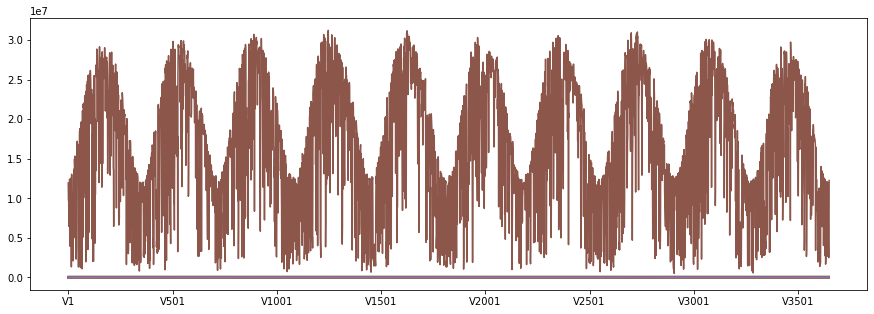

In [11]:
# In the plot, we can see that there are a lot of 0 values in the dataset
train_df.plot(legend=False, figsize=(15, 5))

In [12]:
result = train_df.eq(0.0).sum() / len(train_df) * 100

# Select those columns with more than 30% of zeros
result = result[result > 30.0]
result = result.sort_values(ascending=False)
result

dswrf_s1_1    91.808219
uswrf_s1_1    90.767123
apcp_sf4_1    63.041096
apcp_sf5_1    61.041096
apcp_sf1_1    60.821918
apcp_sf2_1    59.890411
apcp_sf3_1    56.739726
tcdc_ea3_1    37.917808
tcdc_ea1_1    37.808219
tcdc_ea2_1    37.424658
tcdc_ea5_1    36.301370
tcdc_ea4_1    35.726027
dtype: float64

### Observations

As output of the previous cell, we can see that there exist a lot of zeros in the dataset, let's analize if those zeros make sense or not.

The variables with most ammount of zeros (>30%) are:

- **dswrf_s1_1**: Downward short-wave radiative flux average at the surface, at 12:00 UTC, normal to have a lot of zeros as it is not sunny at 12:00
- **uswrf_s1_1**: Upward short-wave radiation at the surface, at 12:00 UTC, normal to have a lot of zeros as it is not sunny at 12:00
- **apcp_s**: 3-Hour accumulated precipitation at the surface, as it is not raining every day, it is normal to have a lot of zeros
- **tcdc_ea**: Total cloud cover over the entire depth of the atmosphere, as it is not cloudy every day, it is normal to have a lot of zeros


First, lets start by assigning the zeros to NaNs. By doing this we can visualize the varibles that take more values other than zero.


In [13]:
disp_df_nan = train_df.replace(0.0, np.nan)

c:\Users\ALEJANDRA\anaconda3\lib\site-packages\missingno\missingno.py:254: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(


ValueError: The number of FixedLocator locations (7), usually from a call to set_ticks, does not match the number of ticklabels (76).

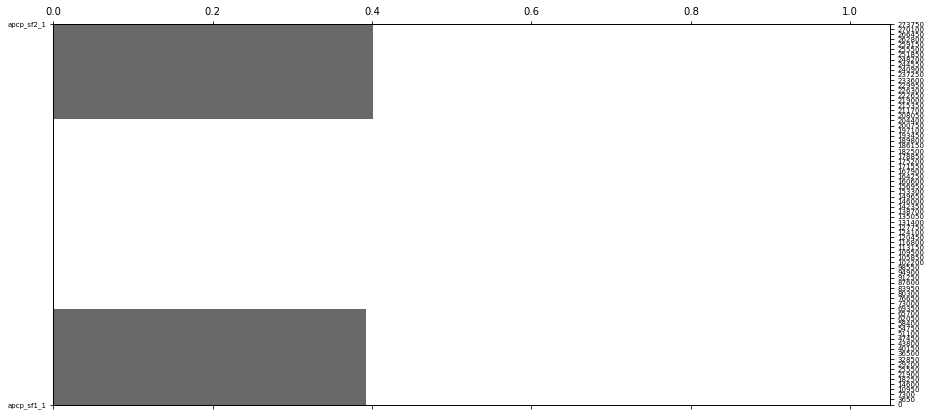

In [14]:
""" Plotting missing values """
# Sustitute 0.0 values with NaN and plot the name of the columns with missing values
# ? msno.bar is a simple visualization of nullity by column
msno.bar(disp_df_nan, labels=True, fontsize=7, figsize=(15, 7))

# Exporting image as png to ../data/img folder
plt.savefig("../data/img/missing_values_bar.png")

In [ ]:
""" Plotting the missing values in a matrix """

# ? The msno.matrix nullity matrix is a data-dense display which lets you quickly visually pick out patterns in data completion.
msno.matrix(disp_df_nan)

# Exporting image as png to ../data/img folder
plt.savefig("../data/img/missing_values_matrix.png")

In [ ]:
""" Plotting the missing values in a heatmap """
# As in a hetmap not every value is shown, we must delimit the values to the ones with more than 30% of missing values
result = disp_df.eq(0.0).sum() / len(disp_df) * 100
result = result[result > 30.0]  # Select those columns with more than 30% of zeros
result = result.sort_values(ascending=False)
result = result.index.tolist()  # Convert to list
result

# ? The missingno correlation heatmap measures nullity correlation: how strongly the presence or absence of one variable affects the presence of another
msno.heatmap(disp_df_nan[result], fontsize=7, figsize=(15, 7))

# Exporting image as png to ../data/img folder
plt.savefig("../data/img/missing_values_heatmap.png")

In [ ]:
""" Plotting the dendrogram """

# ? The dendrogram allows you to more fully correlate variable completion, revealing trends deeper than the pairwise ones visible in the correlation heatmap:
msno.dendrogram(disp_df_nan, orientation="top", fontsize=7, figsize=(15, 7))

# Exporting image as png to ../data/img folder
plt.savefig("../data/img/missing_values_dendrogram.png")

### Conclusions
In this section, we have observe that there are no attibutes with 'Null' nor 'NaN' nor 'None' values. This indicated that at a first glance, the data is clean, at least of those datatypes.

In second place, we have observed that the attributes that we suspected could have an important number of missing values (represented by 0 instead of the previously mentioned), had instead valuable information, as we have proved along this section.<br>Since the data is clean and we have concluded there are no missing values, we do not need to complete them using a model or other methods, so we can move on to the next step, observing the outliers.

## 3.3. Outliers


Detecting outliers in a dataset before training a model is crucial because outliers can significantly affect the performance and accuracy of the model. Outliers are data points that deviate significantly from the rest of the dataset and can cause the model to learn incorrect patterns and relationships. When outliers are present in the data, they can also increase the variance of the model, which can result in overfitting. Overfitting occurs when the model fits too closely to the training data, leading to poor generalization to new data. Therefore, it is important to detect and handle outliers properly to ensure the model's accuracy and robustness.

In [ ]:
list_of_attributes = train_df.columns.values.tolist()
#print(list_of_attributes)

In [ ]:
# Boxplot with all attributes in the dataset
# sns.boxplot(data=train_df, orient="h")
# plt.show()

In [ ]:
train_df.describe()

In [ ]:
train_df['apcp_sf1_1'].value_counts()

Here, by plotting the boxplots and making the outliers (fliers) visible, we are able to see some outliers in the dataset.<br>
Take into account that the outliers are represented by the points outside the boxplot and they can be potentially wrong values or just values that are not usual in the dataset (ruido).

### 3.3.1. Histogram to identify outliers

In [ ]:
""" Histogram showing the distribtuion of train_df to show the outliers """
plt.hist(train_df)
plt.show()

### 3.3.2. Boxplot to identify outliers

With the objective of noticing the outliers on each attribute, we create a box-plot of each of the attributes 

In [ ]:
""" Plotting the boxplot for each attribute and getting the outliers of each attribute """
total_outliers = []
# * We iterate over the list of attributes
for attribute in list_of_attributes:
    # * sns.regplot(x=train_df[attribute], y=train_df['total'], fit_reg=False)
    sns.boxplot(data=train_df[attribute], x=train_df[attribute], orient="h")
    # * Use the command below to show each plot (small size for visualization sake)
    # sns.set(rc={'figure.figsize':(1,.5)})
    # plt.show()
    # * All the images are saved in the folder ../data/img/box-plot
    plt.savefig(f"../data/img/box-plot/{str(attribute)}.png")

    # We obtain the a list of outliers for each attribute
    list_of_outliers = train_df[attribute][train_df[attribute] > train_df[attribute].quantile(0.75) + 1.5*(train_df[attribute].quantile(0.75) - train_df[attribute].quantile(0.25))].tolist()
    outliers = [f'{attribute} outliers'] + [len(list_of_outliers)] + [list_of_outliers]
    # * In order to print the total number of outliers for each attribute
    # print(f'{attribute} has {len(list_of_outliers)} outliers')
    # ! Data structure: [attribute, number of outliers, list of outliers]
    # print(outliers)
    total_outliers.append(outliers)

# print the first 2 elements of each element in the list -> [[atb, num],[atb, num],...]
num_atb_outliers = 0
for i in total_outliers:
    if i[1] != 0:
        num_atb_outliers += 1
        print(f"{i[0:2]}...")
        
# Number of outliers != 0 for each attribute
print(f"Total number of atributes with outliers: {num_atb_outliers} / {len(total_outliers)-1}")

We managed to create a list containing the name of the atribute, the number of outliers and the value of the outliers for each attribute, calculated by applying the IQR method.<br> This is relevant as we managed to create a 'total_outliers' variable that contains the list data structures of all the different outliers from all the attributes, so that it can be easily accessed in a future to remove the outliers from the dataset if needed for testing purposes.

As suspected, we can see that **there are a lot of outliers in the dataset**, therefore it is plausible that some of them are noise, thus possibly being removed in a future model in order to improve it (either by hand or by selection in the preprocess pipeline).<br>Now, we need to analyze if they are the result of bad measurements or if they are significant data for the analysis.


Additionaly, as we will see later, this amount of outliers indicate us that probably a Robust Scaler will be more appropriate than using a Standard Scaler, as the Robust Scaler is more robust to outliers than the Standard Scaler, thus being more appropriate for this dataset model.

### 3.3.3. Skewness and Kurtosis to identify outliers
Skewness and kurtosis are commonly used to measure the shape of a distribution. Skewness measures the degree of asymmetry in the distribution, while kurtosis measures the degree of flatness in the distribution compared to a normal distribution.
We will look for observations that are far from the central tendency of the distribution and may indicate the presence of extreme values or data points that do not fit the pattern of the majority of the data (which as expected, happens to be the case in this dataset).

In [ ]:
""" Skewness """
# ? skewness: measure of the asymmetry of the probability distribution of a real-valued random variable about its mean.
train_df.skew().sort_values(ascending=False)

In [ ]:
""" Kurtosis """
# ? kurtosis: measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution.
train_df.kurt().sort_values(ascending=False)

In [ ]:
y = train_df["apcp_sf4_1"]
plt.figure(1)
plt.title("Normal")
sns.distplot(y, kde=True, fit=st.norm)
plt.figure(2)
plt.title("Log Normal")
sns.distplot(y, kde=True, fit=st.lognorm)

In [ ]:
sns.distplot(train_df.skew(), color="blue", axlabel="Skewness")

In [ ]:
plt.figure(figsize=(12, 8))
sns.distplot(
    train_df.kurt(), color="r", axlabel="Kurtosis", norm_hist=False, kde=True, rug=False
)
# plt.hist(train.kurt(),orientation = 'vertical',histtype = 'bar',label ='Kurtosis', color ='blue')
plt.show()

## 3.4. Correlation


In this section we are getting information about the correlation of the variables between them. This information is valuable in order to make good decisions when deleting redundant attributes. Also note we are getting information about the correlation between each attribute and the solution variable. This allows us to know the most relevant attributes, making the best decisions when creating the different models.  

In [ ]:
correlation = train_df.corr()
correlation = abs(correlation)
print(correlation.shape)  # 76 x 76 matrix of correlation values

### Getting the correlation matrix formatted into our own data structure
This is done for the sake of simplicity and to be able to visualize the correlation matrix in a more intuitive way.


In [ ]:
correlation_list = []

for column in train_df.columns:
    correlation.loc[:, column] = abs(
        correlation.iloc[:, train_df.columns.get_loc(column)]
    )
    mask = correlation.loc[:, column] > 0.95
    # print(correlation[column][mask].sort_values(ascending = False))

    # Translate the comment below to English:
    # we add the correlation values to a list of lists, which contains the names of the correlated columns and their correlation index

    # The first segment adds the name of the column we are analyzing
    # The second segment adds the names of the columns correlated (except the column we are analyzing) > 0.95
    # The third segment adds the correlation index of the columns correlated (except the column we are analyzing) > 0.95
    # Second and third segment are added to the first segment as a list of lists

    # First we need to create a dictionary with the column names and their correlation values (except the column we are analyzing)
    dict = {
        key: value
        for key, value in correlation.loc[column, mask]
        .sort_values(ascending=False)
        .iloc[1:]
        .to_dict()
        .items()
    }
    # print (dict)

    # Then we create a list of lists with the column names and their correlation values from the dictionary created above
    corr_list = [[key] + [value] for key, value in dict.items()]
    # Finally we add the name of the column we are analyzing to the list of lists created above as the first element of the list (str)
    corr_list.insert(0, ["Columna: " + column])

    # ! Data structure: [[columna, [columna correlada 1, indice de correlacion], [columna correlada 2, indice de correlacion], ...], ...]
    print(corr_list)

    correlation_list += [corr_list]
print(correlation_list)

### Correlation Heat Map

In [ ]:
""" seaborne Correlation Heat Map """
# It needs to show all the columns
fig, ax = plt.subplots(figsize=(19, 18))

plt.title("Correlation Heat Map", y=1)
# We use blue color scale because it is easier to see the annotations and the correlation values
sns.heatmap(
    correlation,
    square=True,
    cmap="Blues",
    annot=True,
    fmt=".2f",
    annot_kws={"size": 4},
    cbar_kws={"shrink": 0.5},
    vmin=0.0,
    vmax=1,
)
# We can modify vmax=0.95 in order to get same color scale for values with more than 0.95 correlation
# Note: it delays around 15 seconds as it needs to plot a 76*76 matrix with its 5766 correlation values

# Exporting image as png to ../data/img folder - easier to visualize the annotations, better resolution
plt.savefig("../data/img/correlation_heatmap.png", dpi=200)

We can observe clearly how there are a lot of correlations between the different attributes, which is expected as they are all weather related variables.<br> This is important to know as it will allow us to know which attributes are redundant and which ones are not, so that we can delete the redundant ones in order to improve the model. <br><br> Once obtained the most correlated columns of the dataset, we can plot them and visualize their correlation.

In [ ]:
# 1
columns = ['apcp_sf1_1', 'apcp_sf2_1', 'apcp_sf3_1','apcp_sf4_1', 'apcp_sf5_1']

sns.pairplot(train_df[columns], height = 1, kind ='scatter',diag_kind='kde')
plt.show()

In [ ]:
# 2
columns = [ 'dlwrf_s1_1', 'dlwrf_s2_1', 'dlwrf_s3_1', 'dlwrf_s4_1', 'dlwrf_s5_1']

sns.pairplot(train_df[columns], height = 1, kind ='scatter',diag_kind='kde')
plt.show()

In [ ]:
# 3
columns = ['pwat_ea1_1', 'pwat_ea2_1','pwat_ea3_1','pwat_ea4_1','pwat_ea5_1', 'dlwrf_s1_1', 'dlwrf_s2_1', 'dlwrf_s3_1', 'dlwrf_s4_1', 'dlwrf_s5_1']

sns.pairplot(train_df[columns], height = 1, kind ='scatter',diag_kind='kde')
plt.show()

In [ ]:
# 4
columns = ['dswrf_s1_1', 'dswrf_s2_1', 'dswrf_s3_1', 'dswrf_s4_1', 'dswrf_s5_1']

sns.pairplot(train_df[columns], height = 1, kind ='scatter',diag_kind='kde')
plt.show()

In [ ]:
# 5
columns = ['dswrf_s1_1', 'dswrf_s2_1', 'dswrf_s3_1', 'dswrf_s4_1', 'dswrf_s5_1', 'uswrf_s1_1', 'uswrf_s2_1', 'uswrf_s3_1', 'uswrf_s4_1', 'uswrf_s5_1']

sns.pairplot(train_df[columns], height = 1, kind ='scatter',diag_kind='kde')
plt.show()

In [ ]:
# 6
columns = ['pres_ms1_1', 'pres_ms2_1', 'pres_ms3_1', 'pres_ms4_1', 'pres_ms5_1']

sns.pairplot(train_df[columns], height = 1, kind ='scatter',diag_kind='kde')
plt.show()

In [ ]:
# 7
columns = ['pwat_ea1_1', 'pwat_ea2_1','pwat_ea3_1','pwat_ea4_1','pwat_ea5_1', 'spfh_2m1_1', 'spfh_2m2_1', 'spfh_2m3_1', 'spfh_2m4_1', 'spfh_2m5_1']

sns.pairplot(train_df[columns], height = 1, kind ='scatter',diag_kind='kde')
plt.show()

In [ ]:
# 8
columns = ['spfh_2m1_1', 'spfh_2m2_1', 'spfh_2m3_1', 'spfh_2m4_1', 'spfh_2m5_1','ulwrf_s1_1', 'ulwrf_s2_1', 'ulwrf_s3_1', 'ulwrf_s4_1', 'ulwrf_s5_1']

sns.pairplot(train_df[columns], height = 1, kind ='scatter',diag_kind='kde')
plt.show()

In [ ]:
# 9
columns = ['tmax_2m1_1', 'tmax_2m2_1', 'tmax_2m3_1', 'tmax_2m4_1', 'tmax_2m5_1', 'tmin_2m1_1', 'tmin_2m2_1', 'tmin_2m3_1', 'tmin_2m4_1', 'tmin_2m5_1','tmp_2m_1_1', 'tmp_2m_2_1', 'tmp_2m_3_1', 'tmp_2m_4_1', 'tmp_2m_5_1', 'tmp_sfc1_1', 'tmp_sfc2_1', 'tmp_sfc3_1', 'tmp_sfc4_1', 'tmp_sfc5_1','ulwrf_s1_1', 'ulwrf_s2_1', 'ulwrf_s3_1', 'ulwrf_s4_1', 'ulwrf_s5_1']

sns.pairplot(train_df[columns], height = 1 ,kind ='scatter',diag_kind='kde')
plt.show()

In [ ]:
# 10
columns = ["ulwrf_t1_1", "ulwrf_t2_1", "ulwrf_t3_1"]

sns.pairplot(train_df[columns], height=1, kind="scatter", diag_kind="kde")
plt.show()

In [ ]:
# 11
columns = ['ulwrf_t4_1', 'ulwrf_t5_1', ]

sns.pairplot(train_df[columns], height = 1 ,kind ='scatter',diag_kind='kde')
plt.show()


In [ ]:
# 12
columns = ["uswrf_s2_1", "uswrf_s3_1", "uswrf_s4_1", "uswrf_s5_1"]

sns.pairplot(train_df[columns], height=1, kind="scatter", diag_kind="kde")
plt.show()

In the graphs above, we can observe that the most correlated variables exhibit a linear (and non linear) relationship between them and with the output. This is evident in the diagonal pattern in the graph, indicating that both variables increase or decrease together.

As we have previously mentioned, this is expected as the variables are all weather-related, such as radiative waves, rain, and clouds. It is normal for them to exhibit correlation at different times of the day within the same day, and it is important to consider this when creating the model and eliminating redundant variables as highly correlated variables provide redundant information and can negatively impact model performance. By identifying and removing redundant variables, the model becomes more focused, interpretable, and less prone to overfitting.

---
# 4. Train-Test division 

Since we are working with a time dependent data, we need to avoid mixing it. Also, we are required to add the first 10 years of data to the train set and the last 2 years to the test set. This means we are assigning a 83.333333 percent of the data to train and a 16.66666666 to test.

**Note**: This division was already done before the EDA. We overwrite it to start from a clean state.

Note: `iloc` is useful when we want to split data based on the index or other criteria, while `train_test_split` is useful when wanting to randomly split data into training and testing subsets.<br>
Therefore, we will use `iloc` to split the data into train and test sets as we are dealing with time dependent data.

In [15]:
import time
import matplotlib.pyplot as plt

# Import the metrics from sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.pipeline import Pipeline

# As we have noted during the EDA, for this dataset full of outliers, its preferable to use the RobustScaler
# Although this wont make a huge difference
from sklearn.preprocessing import StandardScaler, RobustScaler

from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, GridSearchCV

## 4.1. Train-Test split

In [16]:
""" Train Test Split (time series) """

np.random.seed(10)

# * Make a copy of the dataframe (as Padas dataframe is mutable, therefore uses a reference)
disp_df_copy = disp_df.copy()

# print(disp_df)
# print(disp_df_copy)

# Now we make the train_x, train_y, test_x, test_y splits taking into account the time series
# Note: the time series is ordered by date, therefore we need to split the data in a way that the train data is before the test data
# Note: the 10 first years are used for training and the last two years for testing
# Note: this is done because if not, we will be predicting the past from the future, which leads to errors and overfitting (data leakage) in the model

# * Calculate the number of rows for training and testing
num_rows = disp_df_copy.shape[0]
num_train_rows = int(
    num_rows * 10 / 12
)  # 10 first years for training, 2 last years for testing

# * Split the data into train and test dataframes (using iloc instead of train_test_split as it picks random rows)
train_df = disp_df_copy.iloc[
    :num_train_rows, :
]  # train contains the first 10 years of rows
test_df = disp_df_copy.iloc[
    num_train_rows:, :
]  # test contains the last 2 years of rows

# Print the number of rows for each dataframe
print(f"Number of rows for training: {train_df.shape[0]}")
print(f"Number of rows for testing: {test_df.shape[0]}")

# Print the dataframes
# print(train_df), print(test_df)

# * Separate the input features and target variable for training and testing
X_train = train_df.drop("salida", axis=1)  # This is the input features for training
y_train = train_df["salida"]  # This is the target variable for training
X_test = test_df.drop("salida", axis=1)  # This is the input features for testing
y_test = test_df["salida"]  # This is the target variable for testing

# We also make a simulation of the exact 5th fold (4 for training and 1 for testing from the training data)
num_rows_train = train_df.shape[0]
num_train_rows_train = int(num_rows_train * 4 / 5)  # 4 folds for training, 1 fold for testing
train_5th_fold_train_df = train_df.iloc[
    :num_train_rows_train, :
]  # train_5th_fold_train contains the first 4 folds of rows

test_5th_fold_train_df = train_df.iloc[ 
    num_train_rows_train:, :
] # test_5th_fold_train contains the last fold of rows

# * Separate the input features and target variable for training and testing
X_train_5th_fold_train = train_5th_fold_train_df.drop("salida", axis=1)  # This is the input features for training
y_train_5th_fold_train = train_5th_fold_train_df["salida"]  # This is the target variable for training
X_test_5th_fold_train = test_5th_fold_train_df.drop("salida", axis=1)  # This is the input features for testing
y_test_5th_fold_train = test_5th_fold_train_df["salida"]  # This is the target variable for testing

print(f"Number of rows for training in the 5th fold: {train_5th_fold_train_df.shape[0]}")
print(f"Number of rows for testing in the 5th fold: {test_5th_fold_train_df.shape[0]}")

# Print the shapes of the dataframes
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_train_5th_fold_train.shape, y_train_5th_fold_train.shape, X_test_5th_fold_train.shape, y_test_5th_fold_train.shape)

Number of rows for training: 3650
Number of rows for testing: 730
Number of rows for training in the 5th fold: 2920
Number of rows for testing in the 5th fold: 730
(3650, 75) (3650,) (730, 75) (730,) (2920, 75) (2920,) (730, 75) (730,)


## 4.2. Train-Test RMSE and MAE function

This function is used to get the MAE and RMSE values of the diffent models, therefore, it will also show the level of overfitting in the models. To perform this analysis, we compare the results of the training dataset from the first fold created by the time-series split, with the validation results of the same fold. Note that by using the training and validation sets, we avoid using the test set for any analysis, which is not recommended.

As with time split folds the largest one (more training data, as test is the same) is the fifth fold in our case, we will use it to compare the results of the different models and obtain the MAE and RMSE values. This way we can compare the results of the different models and see which one is the best. We could calculate and plot the MAE and RMSE values for each fold, but this would be time consuming and would not provide us with any additional information (we haves tested the different results with the different folds prior to this assumptions).
<br><br>This way, we obtain a rather similar result in train and a relative aproximation of the test results, which is what we are looking for.

Note that we also add the posibility to make the predictions on test, but they will be only used in the final model, as we will see later.

In [18]:
np.random.seed(10)

def train_validation_test(m, model, score, X_train, y_train, test = False, X_test = None, y_test = None):
    
    # Train
    y_train_pred = model.predict(X_train)
    rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
    mae_train = mean_absolute_error(y_train, y_train_pred)

    # Test
    if test:
        y_test_pred = model.predict(X_test)
        rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
        mae_test = mean_absolute_error(y_test, y_test_pred)
    
    # We retrain the model with the partial training data (4 folds) and test it with the 5th fold
    np.random.seed(10)

    m.fit(X = X_train_5th_fold_train, y = y_train_5th_fold_train)
    
    # Train in validation fold (5)
    y_train_validation_pred = m.predict(X_train_5th_fold_train)
     
    rmse_train_validation = mean_squared_error(y_train_5th_fold_train, y_train_validation_pred, squared=False)
    mae_train_validation = mean_absolute_error(y_train_5th_fold_train, y_train_validation_pred)

    # Test in validation fold (5)
    y_test_validation_pred = m.predict(X_test_5th_fold_train)
    
    rmse_test_validation = mean_squared_error(y_test_5th_fold_train, y_test_validation_pred, squared=False)
    mae_test_validation = mean_absolute_error(y_test_5th_fold_train, y_test_validation_pred)
    
    # ! Print results
    print(f"Results of the best estimator of {model.__class__.__name__}")
    print(f"NMAE in validation: {score:.2f}")
    print(f"RMSE train: {rmse_train:.2f}", f"MAE train: {mae_train:.2f}", sep=" | ")
    if test:
        print(f"RMSE test: {rmse_test:.2f}", f"MAE test: {mae_test:.2f}", sep=" | ")
    print(f"RMSE validation train: {rmse_train_validation:.2f}", f"MAE validation train: {mae_train_validation:.2f}", sep=" | ")
    print(f"RMSE validation test: {rmse_test_validation:.2f}", f"MAE validation test: {mae_test_validation:.2f}", sep=" | ")

    # ! Train
    title = f'Prediction Errors (RMSE: {rmse_train:.2f}, MAE: {mae_train:.2f})'
    scatterplot_histogram(X_train, y_train, y_train_pred, "Train", title)

    # ! Test
    if test:
        title = f'Prediction Errors (RMSE: {rmse_test:.2f}, MAE: {mae_test:.2f})'
        scatterplot_histogram(X_test, y_test, y_test_pred, "Test", title)
    
    # ! Train in validation fold (5)
    title = f'Prediction Errors (RMSE: {rmse_train_validation:.2f}, MAE: {mae_train_validation:.2f})'
    scatterplot_histogram(X_train_5th_fold_train, y_train_5th_fold_train, y_train_validation_pred, "Train in validation", title)

    # ! Test in validation fold (5)
    title = f'Prediction Errors (RMSE: {rmse_test_validation:.2f}, MAE: {mae_test_validation:.2f})'
    scatterplot_histogram(X_test_5th_fold_train, y_test_5th_fold_train, y_test_validation_pred, "Test in validation", title)
    
    if test:
        return [score, rmse_train, mae_train, rmse_train_validation, mae_train_validation, rmse_test_validation, mae_test_validation, rmse_test, mae_test,]
    return [score, rmse_train, mae_train, rmse_train_validation, mae_train_validation, rmse_test_validation, mae_test_validation]

def scatterplot_histogram (X, y, y_pred, name, title):
    # Make plots smaller to fit better on the notebook
    plt.rcParams['figure.figsize'] = [5.5, 3.5]
    
    # Train accuracy using scatter plot
    plt.plot(X.iloc[:, [0]], y, ".", label=f"{name}")
    plt.plot(X.iloc[:, [0]], y_pred, "r.", label=f"{name} prediction")
    plt.title(f"{name} scatter plot")
    plt.xlabel(f"{title}")
    plt.legend()
    plt.show()
    
    # Calculate the difference between test predictions and test data
    prediction_errors = y - y_pred
    
    # Plot the distribution of prediction errors    
    plt.hist(prediction_errors, bins=25)
    plt.xlabel(f'{title}')
    plt.ylabel('Frequency')
    plt.title(f"{name} prediction errors")
    plt.show()

## 4.3. Print model results

In [19]:
def print_results(name, model, score, time, test=False):
    print("---------------------------------------------------")
    print(f"{name} best model is:\n\n{model}")
    print("\nParameters:", model.best_params_)

    print(
        f"\nPerformance: NMAE (val): {score[0]}",
        f"RMSE train: {score[1]}",
        f"MAE train: {score[2]}",
        f"RMSE train in validation: {score[3]}",
        f"MAE train in validation: {score[4]}",
        f"RMSE test in validation: {score[5]}",
        f"MAE test in validation: {score[6]}",
        sep=" | ",
    )
    
    if test:
        print(
            f"RMSE test: {score[7]}",
            f"MAE test: {score[8]}",
            sep=" | ",
        )
        

    print(f"Execution time: {time}s")

## 4.4. Validation splits

We calculate the subsets used for training and testing in the different folds of the cross-validation.

In [20]:
def validation_splits(model, X_train):
    dict_folds = {}
    
    for n_splits, (train_index, test_index) in enumerate(model.cv.split(X_train)):
        index = "F" + str(n_splits + 1)
        train_index_formatted = []
        test_index_formatted = []

        for i in range(len(train_index)):
            train_index_formatted.append("V" + str(int(train_index[i] + 1)))

        for i in range(len(test_index)):
            test_index_formatted.append("V" + str(int(test_index[i] + 1)))

        dict_folds[index] = [train_index_formatted, test_index_formatted]
        
    return dict_folds

## Decisions for all models 

For each possible method we have created two different models; One with predefined parameters and the second one with selected parameters. For each model we create a pipeline which includes the escaler ( except for trees and related ) and the model.  Note that we have selected RobustEscaler as our scaling method since we have found several outliers in the EDA. Secondly, we duplicate this two models per method and we add the selection of attributes. Note that the model with no selection of attributes and the one with selection of attributes have a double pipeline. Is a double pipeline since we use the output of the first pipeline ( best hiper-parameters ) directly into the second pipeline in order to avoid innecesary computing cost.

We have decided to train all models in the most similar way possible in order for the results to be comparable. This way, all models with selected parameters use RandomSearch in order to avoid unnecessary computational cost while still producing good results. Secondly, we have decided to use TimeSeriesSplit, which is a useful method when working with time-related data. We also perform a cross-validation within the parameter search in order to avoid optimistic scoring for some parameters. For all models, we are using a 5-fold cross-validation. We also decided to use NMAE as our method for testing error since it provides an easy-to-understand score and reduces the weight of outliers (as observed during the EDA process).

In addition note that in order to create the predefined models we are using gridsearch with just one option in the param-grid. This help us stay consistent in the way we create and compare models, since it provides a way of using cross-validation within the function. 

---
# 5. Basic methods

During this section, we will analyze the performance of three methods: KNN, Regression Trees, and Linear Regression. For each method, we will provide a predefined model and another model with selected hyper-parameters. Our hypothesis is that the selected models will provide better performance, while the predefined ones will be better in terms of timing.

Please note that we will be using GridSearch with only one possibility (the predefined one) for the hyper-parameter to make it easier to create the predefined models. Additionally, we have decided to use RandomSearch for the selection of the parameters as it has been shown to provide good results with much less computing required.

In [21]:
# Three dictionaries to store the results of the models
models, results, times = {}, {}, {}

## 5.1. KNN


KNN (k-Nearest Neighbors) is a non-parametric algorithm used for classification and regression. It works by finding the k closest training examples in the feature space to a new input, and assigns the output value based on the majority class among the k neighbors in the case of classification or the average of the output values in the case of regression(our case). The value of k is a hyperparameter that must be chosen before training the model.

In [22]:
from sklearn.neighbors import KNeighborsRegressor

### 5.1.1. KNN - Predefined parameters

#### 5.1.1.1. KNN - Predefined parameters - No attribute selection

Results of the best estimator of Pipeline
NMAE in validation: -3239984.25
RMSE train: 3517654.38 | MAE train: 2493007.22
RMSE validation train: 3557480.48 | MAE validation train: 2518007.16
RMSE validation test: 4152140.06 | MAE validation test: 2892257.01


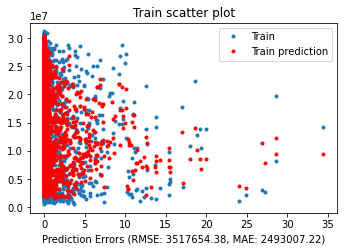

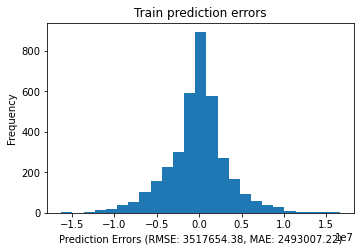

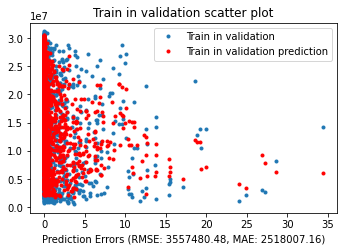

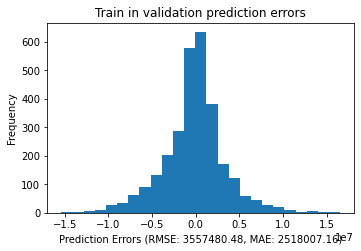

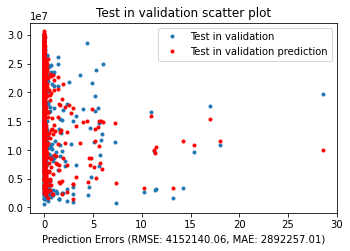

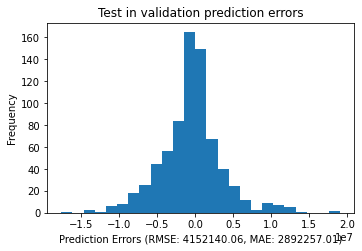

---------------------------------------------------
KNN PREDEFINED PARAMETERS best model is:

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scale', RobustScaler()),
                                       ('model', KNeighborsRegressor())]),
             n_jobs=-1,
             param_grid={'model__algorithm': ['auto'],
                         'model__metric': ['minkowski'],
                         'model__n_neighbors': [5],
                         'model__weights': ['uniform']},
             scoring='neg_mean_absolute_error')

Parameters: {'model__algorithm': 'auto', 'model__metric': 'minkowski', 'model__n_neighbors': 5, 'model__weights': 'uniform'}

Performance: NMAE (val): -3239984.25 | RMSE train: 3517654.379918169 | MAE train: 2493007.2164383563 | RMSE train in validation: 3557480.484807456 | MAE train in validation: 2518007.157534247 | RMSE test in validation: 4152140.058048495 | MAE test in valid

In [23]:
np.random.seed(10)
n_splits = 5

pipeline = Pipeline(
    [
        ("scale", RobustScaler()),
        ("model", KNeighborsRegressor()),
    ]
)

param_grid = {
    "model__n_neighbors": [5],
    "model__weights": ["uniform"],
    "model__metric": ["minkowski"],
    "model__algorithm": ["auto"],
}

model = GridSearchCV(
    pipeline,
    param_grid,
    scoring="neg_mean_absolute_error",
    cv=TimeSeriesSplit(n_splits),
    n_jobs=-1,
)

start_time = time.time()
model.fit(X=X_train, y=y_train)
end_time = time.time()

total_time = end_time - start_time

# We calculate the subsets used for training and testing in the different folds of the cross-validation
# validation_splits(model, X_train)  # We al ready did the 5th fold split at the begginning

# We obtain the different scores of the model
score = train_validation_test(
    model,
    model.best_estimator_,
    model.best_score_,
    X_train,
    y_train,
)

models["KNN_pred"] = model
results["KNN_pred"] = score
times["KNN_pred"] = total_time

print_results("KNN PREDEFINED PARAMETERS", model, score, total_time)

#### 5.1.1.2. KNN - Predefined parameters - Attribute selection

Results of the best estimator of Pipeline
NMAE in validation: -2690780.41
RMSE train: 3108869.52 | MAE train: 2162755.27
RMSE validation train: 3116226.54 | MAE validation train: 2171515.71
RMSE validation test: 3775814.09 | MAE validation test: 2560118.55


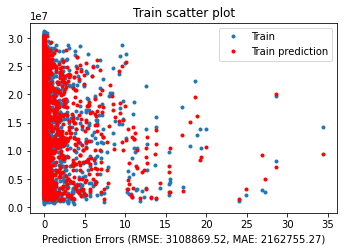

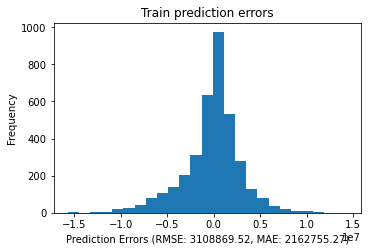

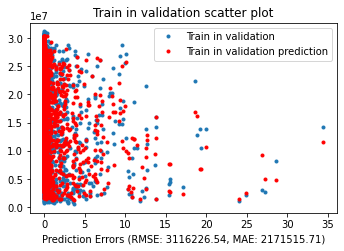

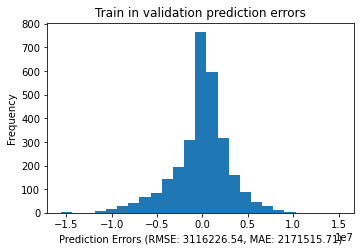

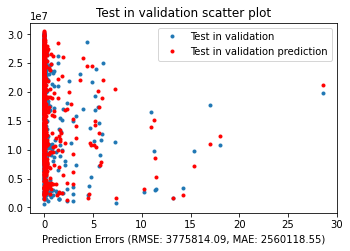

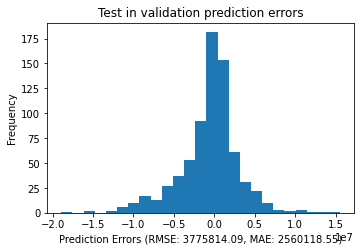

---------------------------------------------------
KNN PREDEFINED PARAMETERS best model is:

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scale', RobustScaler()),
                                       ('select',
                                        SelectKBest(score_func=<function f_regression at 0x0000022A9266B280>)),
                                       ('model', KNeighborsRegressor())]),
             n_jobs=-1,
             param_grid={'model__algorithm': ['auto'],
                         'model__metric': ['minkowski'],
                         'model__n_neighbors': [5],
                         'model__weights': ['uniform'],
                         'select__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26, 27, 28, 29, 30, ...]},
             scoring='neg_mean_abso

In [24]:
np.random.seed(10)
n_splits = 5

# Using a pipeline to scale the data and then apply the model
pipeline = Pipeline(
    [
        ("scale", RobustScaler()),
        ("select", SelectKBest(f_regression)),
        ("model", KNeighborsRegressor()),
    ]
)

param_grid = {
    "model__n_neighbors": [5],
    "model__weights": ["uniform"],
    "model__metric": ["minkowski"],
    "model__algorithm": ["auto"],
    "select__k": list(range(1, X_train.shape[1] + 1)),
}

model = GridSearchCV(
    pipeline,
    param_grid,
    scoring="neg_mean_absolute_error",
    cv=TimeSeriesSplit(n_splits),
    n_jobs=-1,
)

start_time = time.time()
model.fit(X=X_train, y=y_train)
end_time = time.time()

# We calculate the subsets used for training and testing in the different folds of the cross-validation
# validation_splits(model, X_train)  # We al ready did the 5th fold split at the begginning

# We obtain the different scores of the model
score = train_validation_test(
    model,
    model.best_estimator_,
    model.best_score_,
    X_train,
    y_train,
)

models["KNN_pred_k"] = model
results["KNN_pred_k"] = score
times["KNN_pred_k"] = total_time

print_results("KNN PREDEFINED PARAMETERS", model, score, total_time)

Since the NMAE is normalized by the mean absolute error of the test set, it is expected to be different from the MAE calculated directly using the mean_absolute_error function. The NMAE is a way to evaluate the performance of a model in a cross-validation setting, while the MAE is a direct measure of the model's performance on the training set.

Therefore, as we can not use the results of RMSE nor MAE in test, we will use the NMAE scoring given in validation to select the best model (as it is a fairly correct aproximation).

###  5.1.2. KNN - Selected parameters

As seen during the EDA, we have a lot of outliers in the dataset, so we will use a Robust Scaler to scale the data, as it is more robust to outliers than the Standard Scaler or the MinMax Scaler.

In order to make the process of comparing the Selected parameters with the Predefined parameters, we will create two different models, one for each set of parameters, created one from another with the best parameters found in the previous step and a pipeline with the preprocessing steps.

#### 5.1.2.1. KNN - Selected parameters - No attribute selection

For this model, as explained in the introduction of the section, the main parameter is the number of neighbors considered. Additionally, we have decided to add other relevant parameters that should be chosen:

- The metric: KNN is a model based on the distances of the data points, so the way we measure this distance affects the results.
- The weights: We can decide whether we give the same importance to all neighbors or if the closest neighbors should have a greater impact on the result.
- The algorithm: Different algorithms can be used to compute the nearest neighbors: a brute-force approach that compares all data points or a tree-based approach that partitions the data space. The latter is typically faster but may not always provide the best results.

Results of the best estimator of Pipeline
NMAE in validation: -2880131.56
RMSE train: 0.00 | MAE train: 0.00
RMSE validation train: 0.00 | MAE validation train: 0.00
RMSE validation test: 3732609.98 | MAE validation test: 2587777.13


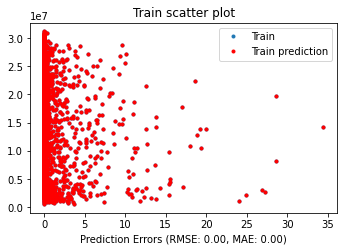

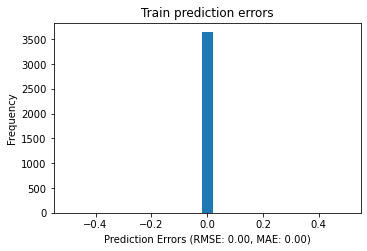

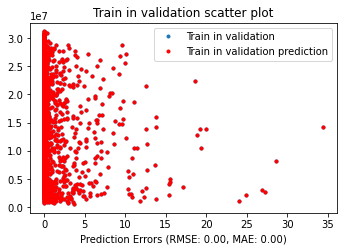

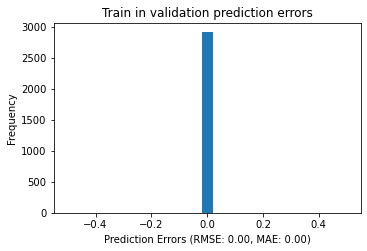

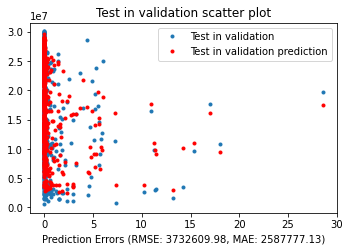

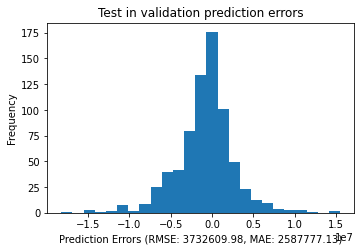

---------------------------------------------------
KNN SELECTED PARAMETERS best model is:

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                             ('model', KNeighborsRegressor())]),
                   n_iter=75, n_jobs=-1,
                   param_distributions={'model__algorithm': ['auto',
                                                             'ball_tree',
                                                             'kd_tree',
                                                             'brute'],
                                        'model__metric': ['euclidean',
                                                          'manhattan',
                                                          'minkowski',
                                                          'chebyshev'],
                                        'model_

In [25]:
np.random.seed(10)
budget = 75
n_splits = 5

pipeline = Pipeline(
    [
        ("scaler", RobustScaler()),
        ("model", KNeighborsRegressor()),
    ]
)

param_grid = {
    "model__n_neighbors": list(range(1, 50, 2)),
    "model__weights": ["uniform", "distance"],
    "model__metric": ["euclidean", "manhattan", "minkowski", "chebyshev"],
    "model__algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
}

model = RandomizedSearchCV(
    pipeline,
    param_grid,
    scoring="neg_mean_absolute_error",
    cv=TimeSeriesSplit(
        n_splits
    ),  # TimeSeriesSplit to split the data in folds without losing the temporal order
    n_iter=budget,
    n_jobs=-1,
)

start_time = time.time()
model.fit(X=X_train, y=y_train)
end_time = time.time()

total_time = end_time - start_time

# We calculate the subsets used for training and testing in the different folds of the cross-validation
# validation_splits(model, X_train)  # We al ready did the 5th fold split at the begginning

# We obtain the different scores of the model
score = train_validation_test(
    model,
    model.best_estimator_,
    model.best_score_,
    X_train,
    y_train,
)

models["KNN_select"] = model
results["KNN_select"] = score
times["KNN_select"] = total_time

print_results("KNN SELECTED PARAMETERS", model, score, total_time)

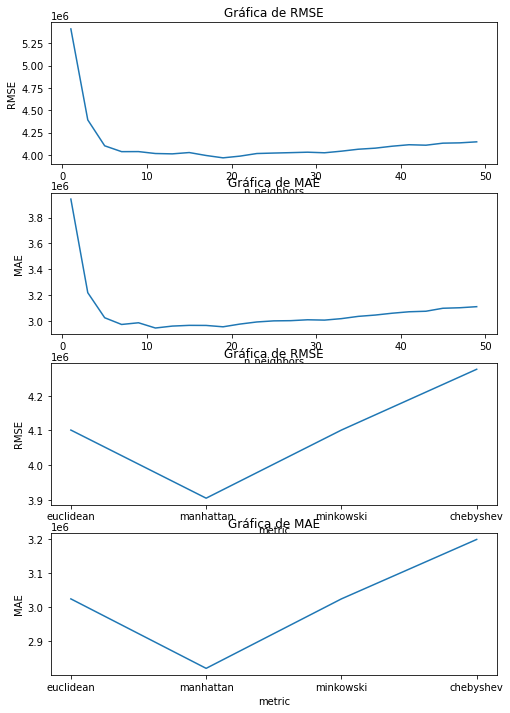

In [26]:
rmse = []
mae = []
rmse2 = []
mae2 = []

for i in range(1, 50, 2): 
    model = KNeighborsRegressor(n_neighbors=i)
    model.fit(X_train_5th_fold_train , y_train_5th_fold_train )
    y_pred = model.predict(X_test_5th_fold_train)
    rmse.append(np.sqrt(mean_squared_error(y_test_5th_fold_train , y_pred)))
    mae.append(mean_absolute_error(y_test_5th_fold_train, y_pred))
    
for i in ["euclidean", "manhattan", "minkowski", "chebyshev"]:
    model = KNeighborsRegressor(metric=i)
    model.fit(X_train_5th_fold_train , y_train_5th_fold_train )
    y_pred = model.predict(X_test_5th_fold_train)
    rmse2.append(np.sqrt(mean_squared_error(y_test_5th_fold_train , y_pred)))
    mae2.append(mean_absolute_error(y_test_5th_fold_train, y_pred))

# Crear dos subplots, uno para cada gráfico
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(8, 12))

# Graficar RMSE vs. n_neighbors en el primer subplot
ax1.plot(list(range(1, 50, 2)), rmse, label="RMSE")
ax1.set_xlabel("n_neighbors")
ax1.set_ylabel("RMSE")
ax1.set_title("Gráfica de RMSE")

# Graficar MAE vs. n_neighbors en el segundo subplot
ax2.plot(list(range(1, 50, 2)), mae, label="MAE")
ax2.set_xlabel("n_neighbors")
ax2.set_ylabel("MAE")
ax2.set_title("Gráfica de MAE")

# Graficar RMSE vs. metric en el tercer subplot
ax3.plot(["euclidean", "manhattan", "minkowski", "chebyshev"], rmse2, label="RMSE")
ax3.set_xlabel("metric")
ax3.set_ylabel("RMSE")
ax3.set_title("Gráfica de RMSE")

# Graficar MAE vs. metric en el cuarto subplot
ax4.plot(["euclidean", "manhattan", "minkowski", "chebyshev"], mae2, label="MAE")
ax4.set_xlabel("metric")
ax4.set_ylabel("MAE")
ax4.set_title("Gráfica de MAE")

# Mostrar los gráficos
plt.show()

#### 5.1.2.2. KNN - Selected parameters - Attribute selection

Results of the best estimator of Pipeline
NMAE in validation: -2603870.87
RMSE train: 1355.34 | MAE train: 31.73
RMSE validation train: 25827.04 | MAE validation train: 675.92
RMSE validation test: 3681057.75 | MAE validation test: 2483096.38


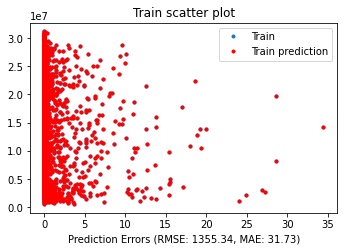

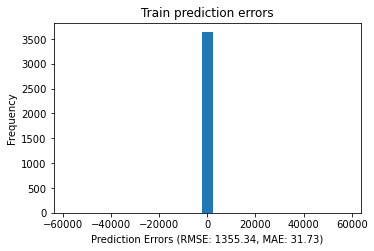

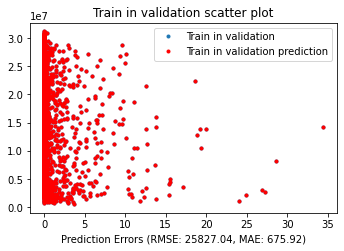

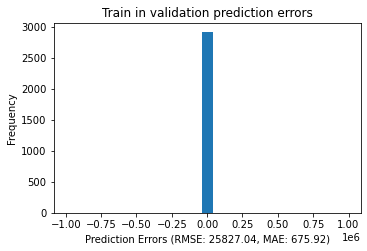

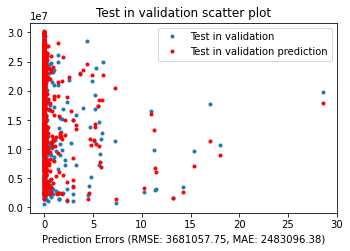

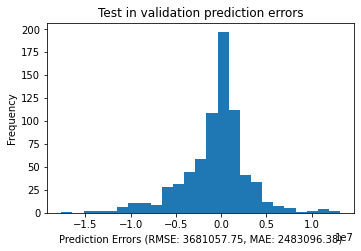

---------------------------------------------------
KNN SELECTED PARAMETERS best model is:

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('select',
                                        SelectKBest(score_func=<function f_regression at 0x0000022A9266B280>)),
                                       ('model', KNeighborsRegressor())]),
             n_jobs=-1,
             param_grid={'model__algorithm': ['kd_tree'],
                         'model__metric': ['manhattan'],
                         'model__n_neighbors': [9],
                         'model__weights': ['distance'],
                         'select__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26, 27, 28, 29, 30, ...]},
             scoring='neg_mean_a

In [27]:
# Now, we will use the previously calculated best model to add the selection of attributes through the SelectKBest function in the pipeline
np.random.seed(10)
n_splits = 5


pipeline = Pipeline(
    [
        ("scaler", RobustScaler()),
        ("select", SelectKBest(f_regression)),
        ("model", KNeighborsRegressor()),
    ]
)

# Previous best model had as parameters: {'model__weights': 'distance', 'model__n_neighbors': 9, 'model__metric': 'manhattan'}
 
param_grid = {
    "model__n_neighbors": [9],
    "model__weights": ["distance"],
    "model__metric": ["manhattan"],
    "model__algorithm": ["kd_tree"],
    "select__k": list(range(1, X_train.shape[1] + 1)),
}

model = GridSearchCV(
    pipeline,
    param_grid,
    scoring="neg_mean_absolute_error",
    cv=TimeSeriesSplit(
        n_splits
    ),
    n_jobs=-1,
)

start_time = time.time()
model.fit(X=X_train, y=y_train)
end_time = time.time()

total_time = end_time - start_time

# We calculate the subsets used for training and testing in the different folds of the cross-validation
# validation_splits(model, X_train)  # We al ready did the 5th fold split at the begginning

# We obtain the different scores of the model
score = train_validation_test(
    model,
    model.best_estimator_,
    model.best_score_,
    X_train,
    y_train,
)

models["KNN_select_k"] = model
results["KNN_select_k"] = score
times["KNN_select_k"] = total_time

print_results("KNN SELECTED PARAMETERS", model, score, total_time)

## 5.2 Regression Trees

Trees work by recursively partitioning the data into subsets based on the values of their features, creating a tree-like structure that maps each set of features to a predicted target value. Each node in the tree represents a feature, and each branch represents a decision rule based on the value of that feature. The goal is to split the data in a way that creates the most homogeneous subsets with respect to the target variable. Once the tree is constructed, it can be used to make predictions on new data by following the decision rules down the tree until a leaf node is reached, which contains the predicted target value.

Note: In trees (both regression trees and random forests), it is not necessary to scale the data, as the algorithm is not sensitive to the scale of the data.

In [28]:
from sklearn.tree import DecisionTreeRegressor

### 5.2.1. Regression Trees - Predefined parameters

#### 5.2.1.1. Regression Trees - Predefined parameters - No attribute selection

Results of the best estimator of Pipeline
NMAE in validation: -3467149.44
RMSE train: 0.00 | MAE train: 0.00
RMSE validation train: 0.00 | MAE validation train: 0.00
RMSE validation test: 4961507.79 | MAE validation test: 3406755.21


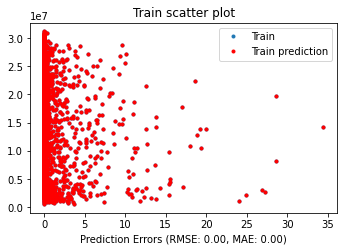

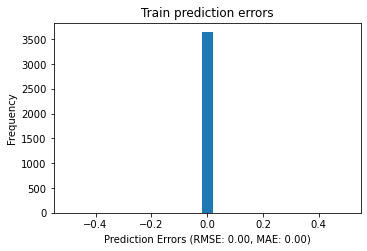

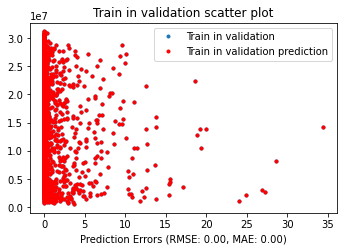

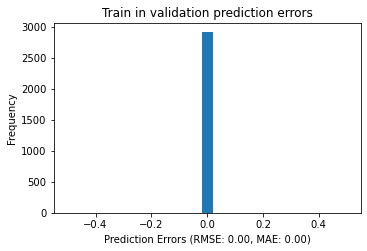

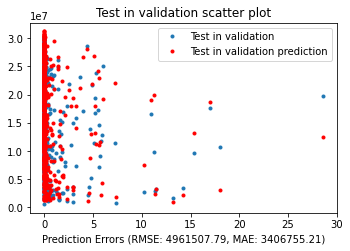

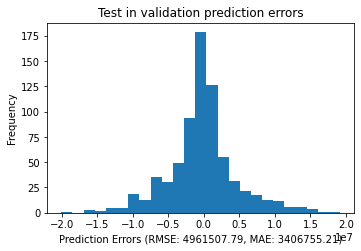

---------------------------------------------------
REGRESSION TREES PREDEFINED PARAMETERS best model is:

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('model',
                                        DecisionTreeRegressor(random_state=1))]),
             n_jobs=-1,
             param_grid={'model__criterion': ['squared_error'],
                         'model__max_depth': [None],
                         'model__max_features': [None],
                         'model__min_samples_split': [2]},
             scoring='neg_mean_absolute_error')

Parameters: {'model__criterion': 'squared_error', 'model__max_depth': None, 'model__max_features': None, 'model__min_samples_split': 2}

Performance: NMAE (val): -3467149.4407894737 | RMSE train: 0.0 | MAE train: 0.0 | RMSE train in validation: 0.0 | MAE train in validation: 0.0 | RMSE test in validation: 4961507.791413844 | MAE test in validation: 3406755.205479452

In [29]:
np.random.seed(10)
n_splits = 5

pipeline = Pipeline(
    [
        ("model", DecisionTreeRegressor(random_state=1)),
    ]
)

param_grid = {
    "model__criterion": ["squared_error"],
    "model__max_depth": [None],
    "model__min_samples_split": [2],
    "model__max_features": [None],
}

model = GridSearchCV(
    pipeline,
    param_grid,
    scoring="neg_mean_absolute_error",
    cv=TimeSeriesSplit(n_splits),
    n_jobs=-1,
)


start_time = time.time()
model.fit(X=X_train, y=y_train)
end_time = time.time()

total_time = end_time - start_time

# We calculate the subsets used for training and testing in the different folds of the cross-validation
# validation_splits(model, X_train)  # We al ready did the 5th fold split at the begginning

# We obtain the different scores of the model
score = train_validation_test(
    model,
    model.best_estimator_,
    model.best_score_,
    X_train,
    y_train,
)

models["RegTrees_pred"] = model
results["RegTrees_pred"] = score
times["RegTrees_pred"] = total_time

print_results("REGRESSION TREES PREDEFINED PARAMETERS", model, score, total_time)

#### 5.2.1.2. Regression Trees - Predefined parameters - Attribute selection

Results of the best estimator of Pipeline
NMAE in validation: -3328832.17
RMSE train: 0.00 | MAE train: 0.00
RMSE validation train: 0.00 | MAE validation train: 0.00
RMSE validation test: 5002502.82 | MAE validation test: 3460965.62


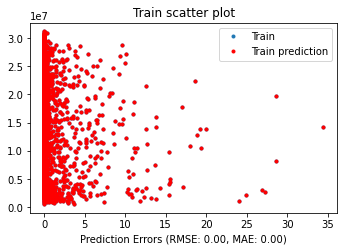

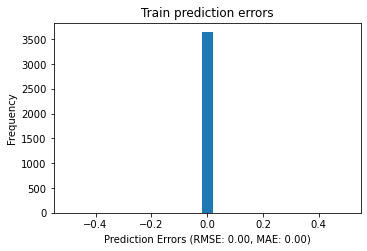

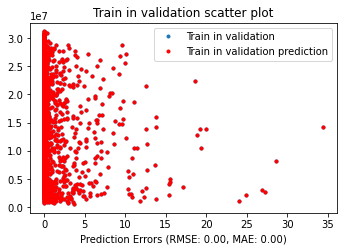

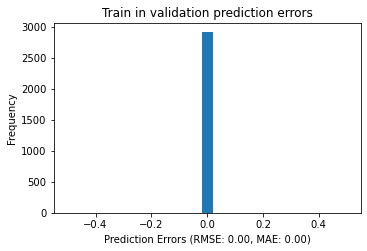

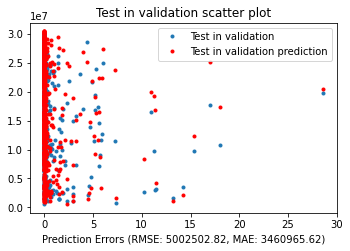

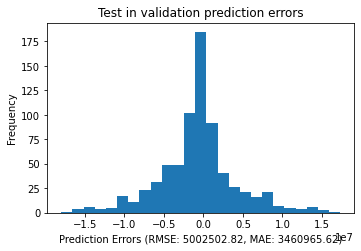

---------------------------------------------------
REGRESSION TREES PREDEFINED PARAMETERS best model is:

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('select',
                                        SelectKBest(score_func=<function f_regression at 0x0000022A9266B280>)),
                                       ('model',
                                        DecisionTreeRegressor(random_state=1))]),
             n_jobs=-1,
             param_grid={'model__criterion': ['squared_error'],
                         'model__max_depth': [None],
                         'model__max_features': [None],
                         'model__min_samples_split': [2],
                         'select__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26, 27, 28, 29, 30, ...]},
             scoring=

In [30]:
np.random.seed(10)
n_splits = 5

pipeline = Pipeline(
    [
        ('select', SelectKBest(f_regression)),
        ("model", DecisionTreeRegressor(random_state=1)),
    ]
)

param_grid = {
    "model__criterion": ["squared_error"],
    "model__max_depth": [None],
    "model__min_samples_split": [2],
    "model__max_features": [None],
    "select__k": list(range(1, X_train.shape[1] + 1)),
}

model = GridSearchCV(
    pipeline,
    param_grid,
    scoring="neg_mean_absolute_error",
    cv=TimeSeriesSplit(n_splits),
    n_jobs=-1,
)


start_time = time.time()
model.fit(X=X_train, y=y_train)
end_time = time.time()

total_time = end_time - start_time

# We calculate the subsets used for training and testing in the different folds of the cross-validation
# validation_splits(model, X_train)  # We al ready did the 5th fold split at the begginning

# We obtain the different scores of the model
score = train_validation_test(
    model,
    model.best_estimator_,
    model.best_score_,
    X_train,
    y_train,
)

models["RegTrees_pred_k"] = model
results["RegTrees_pred_k"] = score
times["RegTrees_pred_k"] = total_time

print_results("REGRESSION TREES PREDEFINED PARAMETERS", model, score, total_time)

#### Note

As we can see, the default model is clearly overfitting, as indicated by the 0 error for the train section and a high error for the test section. This is likely due to the lack of control over the maximum depth of the tree, combined with a small minimum sample split that leaves only one sample in each leaf. This causes the model to memorize each data point, leading to poor generalization performance.


### 5.2.2. Regression Trees - Selected parameters

Building upon the previous definition, we can reduce the most important parameters to be ajusted to the following:
- max_features : controls the numberof features ( or attributes ) used in the tree. 
- min_samples-split : controls the minumum number of instances a leafe must have in order to be able to subdivide. This parameter can prevent the tree from overfitting. 
- max-depth : This parammeter also helps to prevent overfitting by stoping the tree from subdividing to much. 

#### 5.2.2.1. Regression Trees - Selected parameters - No attribute selection

Results of the best estimator of Pipeline
NMAE in validation: -2743220.58
RMSE train: 3259190.45 | MAE train: 2080612.60
RMSE validation train: 3286556.31 | MAE validation train: 2092567.19
RMSE validation test: 3914582.59 | MAE validation test: 2655352.60


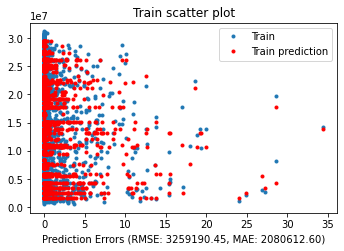

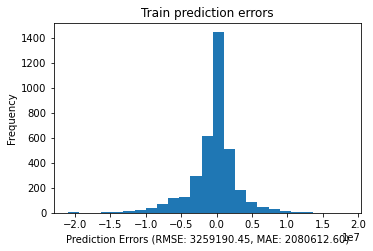

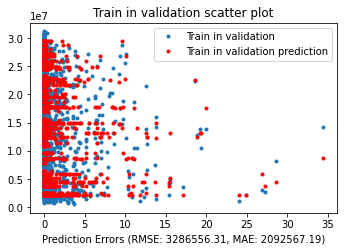

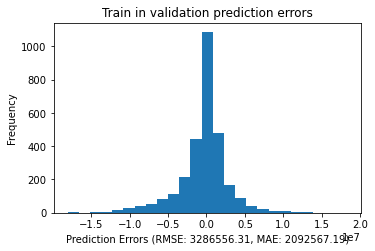

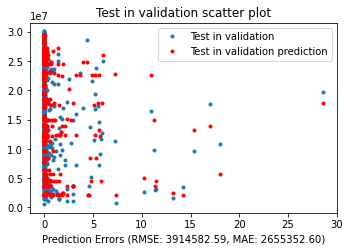

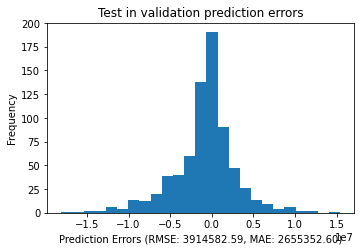

---------------------------------------------------
REGRESSION TREES SELECTED PARAMETERS best model is:

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('model',
                                              DecisionTreeRegressor(random_state=1))]),
                   n_iter=75, n_jobs=-1,
                   param_distributions={'model__criterion': ['absolute_error',
                                                             'squared_error'],
                                        'model__max_depth': [5, 10, 15, 20, 25,
                                                             30, 35, 40, 45, 50,
                                                             55, 60],
                                        'model__max_features': ['sqrt', 'log2',
                                                                None],
                                        'model__min_samples_split': [5, 6, 7

In [31]:
np.random.seed(10)
budget = 75
n_splits = 5

pipeline = Pipeline(
    [
        ("model", DecisionTreeRegressor(random_state=1))
    ]
)

param_grid = {
    "model__criterion": ["absolute_error", "squared_error"],
    "model__max_depth": list(range(5, 61, 5)),
    "model__min_samples_split": list(range(5, 200)),
    "model__max_features": ["sqrt", "log2", None],
}

# We use TimeSeriesSplit to split the data in folds without losing the temporal order
model = RandomizedSearchCV(
    pipeline,
    param_grid,
    scoring="neg_mean_absolute_error",
    cv=TimeSeriesSplit(n_splits),
    n_iter=budget,
    n_jobs=-1,
)

start_time = time.time()
model.fit(X=X_train, y=y_train)
end_time = time.time()

total_time = end_time - start_time

# We calculate the subsets used for training and testing in the different folds of the cross-validation
# validation_splits(model, X_train)  # We al ready did the 5th fold split at the begginning

# We obtain the different scores of the model
score = train_validation_test(
    model,
    model.best_estimator_,
    model.best_score_,
    X_train,
    y_train,
)

models["RegTrees_select"] = model
results["RegTrees_select"] = score
times["RegTrees_select"] = total_time

print_results("REGRESSION TREES SELECTED PARAMETERS", model, score, total_time)

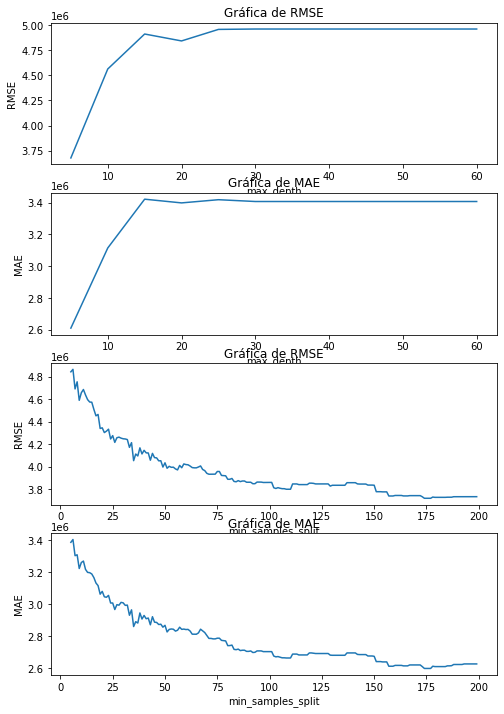

In [32]:
rmse = []
mae = []
rmse2 = []
mae2 = []

for i in range(5, 61, 5): 
    model = DecisionTreeRegressor(random_state=1, max_depth=i)
    model.fit(X_train_5th_fold_train , y_train_5th_fold_train )
    y_pred = model.predict(X_test_5th_fold_train)
    rmse.append(np.sqrt(mean_squared_error(y_test_5th_fold_train , y_pred)))
    mae.append(mean_absolute_error(y_test_5th_fold_train, y_pred))
    
for i in range(5, 200):
    model = DecisionTreeRegressor(random_state=1, min_samples_split=i)
    model.fit(X_train_5th_fold_train , y_train_5th_fold_train )
    y_pred = model.predict(X_test_5th_fold_train)
    rmse2.append(np.sqrt(mean_squared_error(y_test_5th_fold_train , y_pred)))
    mae2.append(mean_absolute_error(y_test_5th_fold_train, y_pred))

# Crear dos subplots, uno para cada gráfico
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(8, 12))

# Graficar RMSE vs. n_neighbors en el primer subplot
ax1.plot(list(range(5, 61, 5)), rmse, label="RMSE")
ax1.set_xlabel("max_depth")
ax1.set_ylabel("RMSE")
ax1.set_title("Gráfica de RMSE")

# Graficar MAE vs. n_neighbors en el segundo subplot
ax2.plot(list(range(5, 61, 5)), mae, label="MAE")
ax2.set_xlabel("max_depth")
ax2.set_ylabel("MAE")
ax2.set_title("Gráfica de MAE")

# Graficar RMSE vs. metric en el tercer subplot
ax3.plot(list(range(5, 200)), rmse2, label="RMSE")
ax3.set_xlabel("min_samples_split")
ax3.set_ylabel("RMSE")
ax3.set_title("Gráfica de RMSE")

# Graficar MAE vs. metric en el cuarto subplot
ax4.plot(list(range(5, 200)), mae2, label="MAE")
ax4.set_xlabel("min_samples_split")
ax4.set_ylabel("MAE")
ax4.set_title("Gráfica de MAE")

# Mostrar los gráficos
plt.show()

#### 5.2.2.2. Regression Trees - Selected parameters - Attribute selection

Results of the best estimator of Pipeline
NMAE in validation: -2727416.15
RMSE train: 3452866.62 | MAE train: 2199234.33
RMSE validation train: 3561457.96 | MAE validation train: 2280089.28
RMSE validation test: 4044668.04 | MAE validation test: 2710957.60


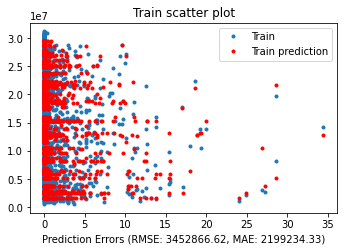

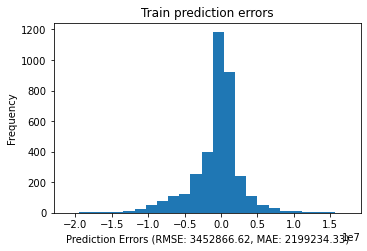

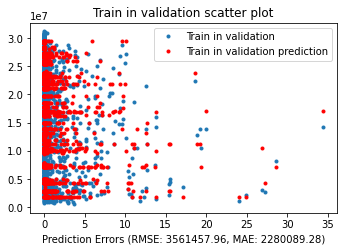

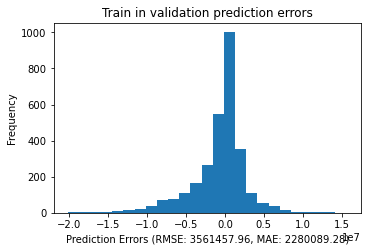

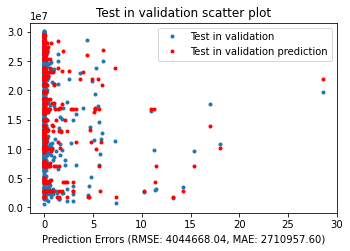

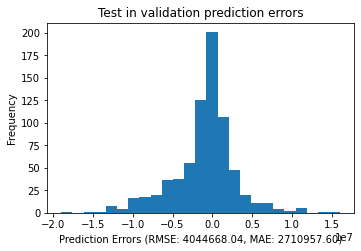

---------------------------------------------------
REGRESSION TREES SELECTED PARAMETERS best model is:

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('select',
                                        SelectKBest(score_func=<function f_regression at 0x0000022A9266B280>)),
                                       ('model',
                                        DecisionTreeRegressor(random_state=1))]),
             n_jobs=-1,
             param_grid={'model__criterion': ['absolute_error'],
                         'model__max_depth': [30],
                         'model__max_features': [None],
                         'model__min_samples_split': [106],
                         'select__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26, 27, 28, 29, 30, ...]},
             scoring='

In [33]:
np.random.seed(10)
n_splits = 5

pipeline = Pipeline(
    [
        ("select", SelectKBest(f_regression)),
        ("model", DecisionTreeRegressor(random_state=1))
    ]
)

# Previous model Parameters: {'model__min_samples_split': 106, 'model__max_features': None, 'model__max_depth': 30, 'model__criterion': 'absolute_error'}

param_grid = {
    "model__criterion": ["absolute_error"],
    "model__max_depth": [30],
    "model__min_samples_split": [106],
    "model__max_features": [None],
    "select__k": list(range(1, X_train.shape[1] + 1)),
}

# We use TimeSeriesSplit to split the data in folds without losing the temporal order
model = GridSearchCV(
    pipeline,
    param_grid,
    scoring="neg_mean_absolute_error",
    cv=TimeSeriesSplit(n_splits),
    n_jobs=-1,
)

start_time = time.time()
model.fit(X=X_train, y=y_train)
end_time = time.time()

total_time = end_time - start_time

# We calculate the subsets used for training and testing in the different folds of the cross-validation
# validation_splits(model, X_train)  # We al ready did the 5th fold split at the begginning

# We obtain the different scores of the model
score = train_validation_test(
    model,
    model.best_estimator_,
    model.best_score_,
    X_train,
    y_train,
)

models["RegTrees_select_k"] = model
results["RegTrees_select_k"] = score
times["RegTrees_select_k"] = total_time

print_results("REGRESSION TREES SELECTED PARAMETERS", model, score, total_time)

## 5.3 Linnear Regression

Linear regression is a supervised learning algorithm that models the relationship between a dependent variable and one or more independent variables by fitting a linear equation to the observed data. The goal is to find the best fit line that can predict the dependent variable given the independent variables.

For the selected model we will be considering Lasso and Ridge.
Lasso and Ridge regression are two popular regularization techniques used with linear regression. Lasso adds a penalty term to the regression equation that encourages the model to minimize the absolute value of the regression coefficients, which can lead to some coefficients being exactly zero. Ridge regression, on the other hand, adds a penalty term that encourages the model to minimize the square of the regression coefficients, which can help prevent overfitting. These techniques can improve the performance of the linear regression model by reducing the impact of irrelevant or highly correlated features.

In [34]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

### 5.3.1. Linear Regression - Predefined parameters

#### 5.3.1.1. Linear Regression - Predefined parameters - No attribute selection

Results of the best estimator of Pipeline
NMAE in validation: -2437056.06
RMSE train: 3254352.60 | MAE train: 2321647.06
RMSE validation train: 3265297.88 | MAE validation train: 2322380.61
RMSE validation test: 3268115.48 | MAE validation test: 2265683.80


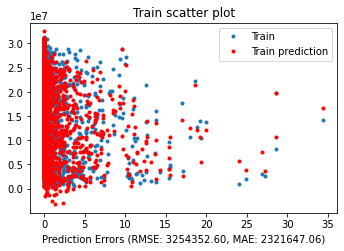

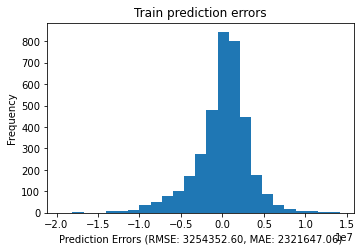

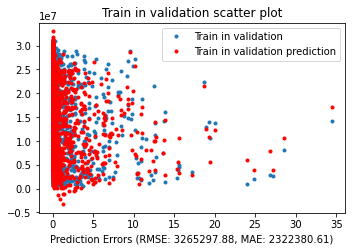

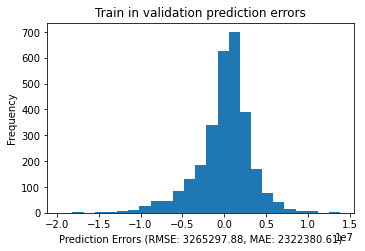

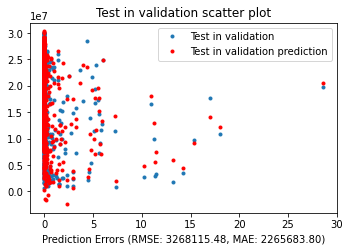

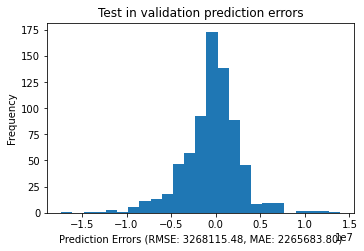

---------------------------------------------------
LINEAR REGRESSION PREDEFINED PARAMETERS best model is:

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('model', LinearRegression())]),
             n_jobs=-1, param_grid={'model__fit_intercept': [True]},
             scoring='neg_mean_absolute_error')

Parameters: {'model__fit_intercept': True}

Performance: NMAE (val): -2437056.0592061607 | RMSE train: 3254352.603690468 | MAE train: 2321647.05970324 | RMSE train in validation: 3265297.879240584 | MAE train in validation: 2322380.6106294747 | RMSE test in validation: 3268115.4760430297 | MAE test in validation: 2265683.802964307
Execution time: 0.26170992851257324s


In [35]:
np.random.seed(10)
n_splits = 5

pipeline = Pipeline([("scaler", RobustScaler()), ("model", LinearRegression())])

param_grid = {
    "model__fit_intercept": [True],
}

model = GridSearchCV(
    pipeline,
    param_grid,
    scoring="neg_mean_absolute_error",
    cv=TimeSeriesSplit(n_splits),
    n_jobs=-1,
)

start_time = time.time()
model.fit(X=X_train, y=y_train)
end_time = time.time()

total_time = end_time - start_time

# We calculate the subsets used for training and testing in the different folds of the cross-validation
# validation_splits(model, X_train)  # We al ready did the 5th fold split at the begginning

# We obtain the different scores of the model
score = train_validation_test(
    model,
    model.best_estimator_,
    model.best_score_,
    X_train,
    y_train,
)

models["LinearReg_pred"] = model
results["LinearReg_pred"] = score
times["LinearReg_pred"] = total_time

print_results("LINEAR REGRESSION PREDEFINED PARAMETERS", model, score, total_time)

#### 5.3.1.2. Linear Regression - Predefined parameters - No attribute selection

Results of the best estimator of Pipeline
NMAE in validation: -2421796.65
RMSE train: 3256574.00 | MAE train: 2323171.61
RMSE validation train: 3267629.55 | MAE validation train: 2322601.75
RMSE validation test: 3267567.88 | MAE validation test: 2263068.40


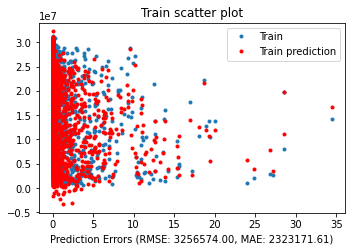

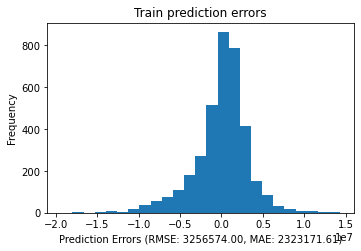

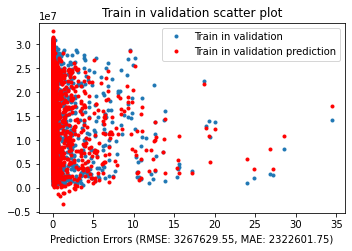

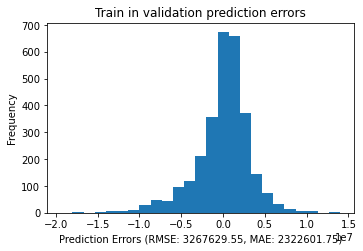

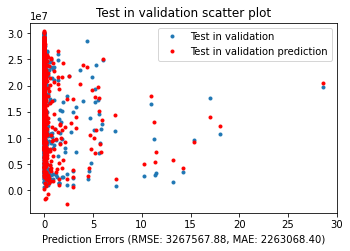

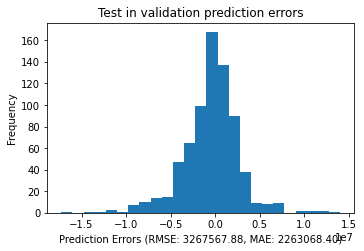

---------------------------------------------------
LINEAR REGRESSION PREDEFINED PARAMETERS best model is:

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('select',
                                        SelectKBest(score_func=<function f_regression at 0x0000022A9266B280>)),
                                       ('model', LinearRegression())]),
             n_jobs=-1,
             param_grid={'model__fit_intercept': [True],
                         'select__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26, 27, 28, 29, 30, ...]},
             scoring='neg_mean_absolute_error')

Parameters: {'model__fit_intercept': True, 'select__k': 72}

Performance: NMAE (val): -2421796.652193799 | RMSE train: 3256573.9989301027

In [36]:
np.random.seed(10)
n_splits = 5

pipeline = Pipeline(
    [
        ("scaler", RobustScaler()),
        ("select", SelectKBest(f_regression)),
        ("model", LinearRegression()),
    ]
)

param_grid = {
    "model__fit_intercept": [True],
    "select__k": list(range(1, X_train.shape[1] + 1)),
}

model = GridSearchCV(
    pipeline,
    param_grid,
    scoring="neg_mean_absolute_error",
    cv=TimeSeriesSplit(n_splits),
    n_jobs=-1,
)


start_time = time.time()
model.fit(X=X_train, y=y_train)
end_time = time.time()

total_time = end_time - start_time

# We calculate the subsets used for training and testing in the different folds of the cross-validation
# validation_splits(model, X_train)  # We al ready did the 5th fold split at the begginning

# We obtain the different scores of the model
score = train_validation_test(
    model,
    model.best_estimator_,
    model.best_score_,
    X_train,
    y_train,
)

models["LinearReg_pred_k"] = model
results["LinearReg_pred_k"] = score
times["LinearReg_pred_k"] = total_time

print_results("LINEAR REGRESSION PREDEFINED PARAMETERS", model, score, total_time)

### 5.3.2. Linear Regression - Selected parameters

Expanding upon the previous discussion, when using **Lasso** regression, we can focus on adjusting the following key parameters:

- **alpha**: This parameter determines the amount of regularization applied to the model. A higher alpha results in stronger regularization, which can help to reduce overfitting.
- **k**: This parameter determines the number of features selected by the Lasso model. By adjusting k, we can control the complexity of the model and potentially improve its performance.
It's worth noting that these are just a few of the many parameters that can be adjusted when using Lasso regression. However, by focusing on these key parameters, we can gain a better understanding of how the model works and how to optimize its performance.



We can reduce the most important parameters to be adjusted for **Ridge** regression to the following:

- **alpha**: controls the strength of the regularization penalty applied to the coefficients. A high alpha value can lead to underfitting, while a low alpha value can lead to overfitting.
- **k**: the number of top features selected by the SelectKBest function. This parameter determines the number of features to be used in the model and can have an impact on its performance.


Similarly, we can reduce the most important parameters for **Elastic Net** regression to be adjusted to the following:

- **alpha**: controls the regularization strength of both L1 and L2 penalties. A high alpha will increase the regularization strength, while a low alpha will decrease it.
- **l1_ratio**: controls the ratio between L1 and L2 penalties. A l1_ratio of 1 is equivalent to Lasso regression, while a ratio of 0 is equivalent to Ridge regression.
- **k**: the number of features to be selected by the SelectKBest method. This parameter is part of the pipeline and helps to select the most relevant features for the model.
Adjusting these parameters can help prevent overfitting and improve the performance of the Elastic Net regression model.

Note: due to scikit learn internal implementation of the Elastic Net model, we can obtain Lasso model by setting l1_ratio to 1 but not Ridge model by setting l1_ratio to 0, which is strange. This results in a poor performance of Elastic Net model, as for this dataset, Ridge model is way more efficient than Lasso model.<br>This could be occurring due to the dataset itself (outliers, correlations...), the dataset handling, the library version, the dependencies, the python version, or the virtual environment.


#### 5.3.2.1. Linear Regression - Selected parameters - Attribute Selection

Model: -2916665.224197623
{'model__alpha': 52025.49442372698}
Results of the best estimator of Pipeline
NMAE in validation: -2916665.22
RMSE train: 3876831.69 | MAE train: 2906173.48
RMSE validation train: 3922101.26 | MAE validation train: 2937813.23
RMSE validation test: 3923699.07 | MAE validation test: 2858386.71


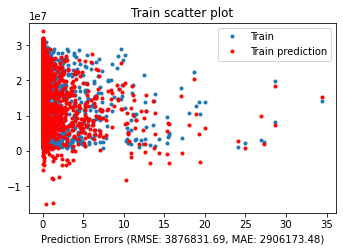

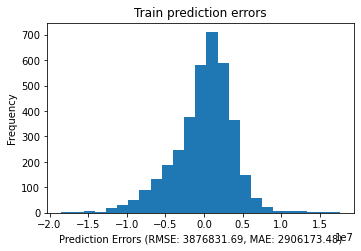

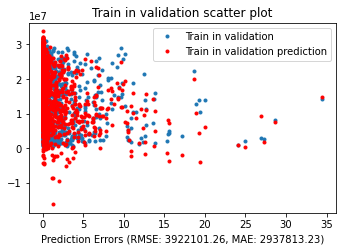

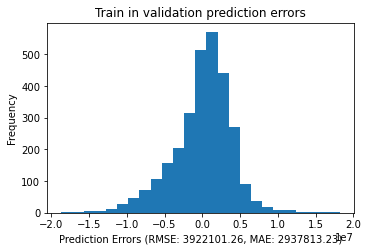

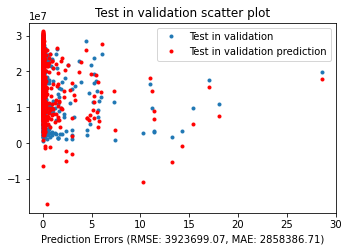

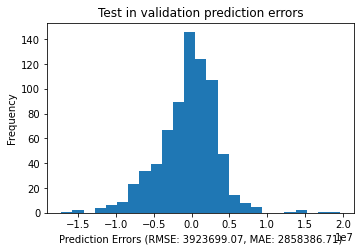

Model: -2396352.0117066414
{'model__alpha': 0.9693631061142517}
Results of the best estimator of Pipeline
NMAE in validation: -2396352.01
RMSE train: 3276534.92 | MAE train: 2333075.68
RMSE validation train: 3292824.95 | MAE validation train: 2337932.29
RMSE validation test: 3280253.30 | MAE validation test: 2260087.83


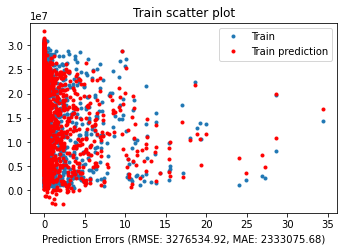

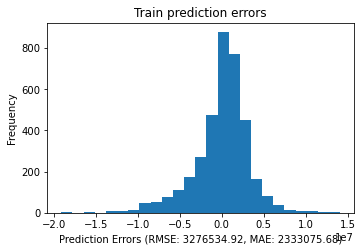

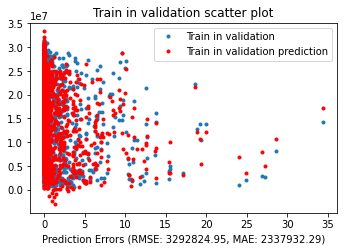

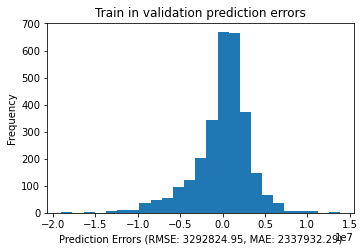

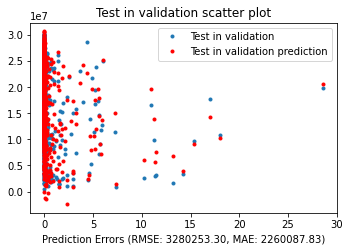

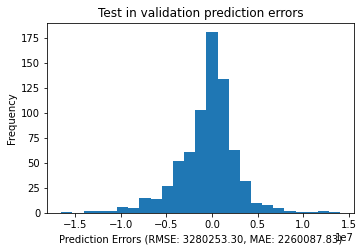

Model: -2658838.747674453
{'model__l1_ratio': 0.43243243243243246, 'model__alpha': 0.26237286577779917}
Results of the best estimator of Pipeline
NMAE in validation: -2658838.75
RMSE train: 3592222.21 | MAE train: 2660152.84
RMSE validation train: 3604425.08 | MAE validation train: 2661450.93
RMSE validation test: 3576311.08 | MAE validation test: 2558163.00


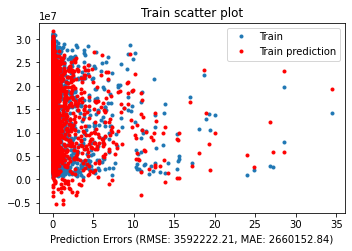

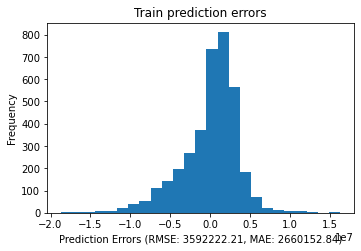

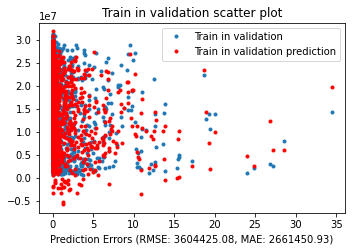

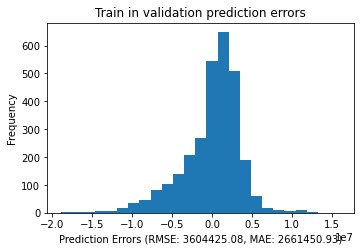

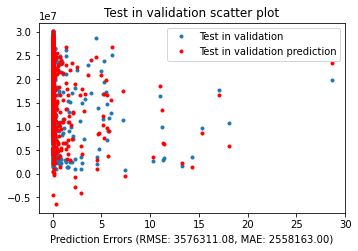

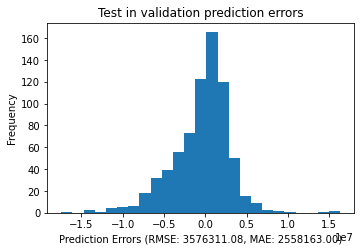

[3.903712511062622, 3.960240125656128, 3.826535224914551]
---------------------------------------------------
LINEAR REGRESSION SELECTED PARAMETERS best model is:

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                             ('model',
                                              Ridge(random_state=10))]),
                   n_iter=75, n_jobs=-1,
                   param_distributions={'model__alpha': array([ 0.01      ,  0.01097844,  0.01205261,  0.01323188,  0.01452654,
        0.01594787,  0.01750827,  0.01922135,  0.02110203,  0.02316674,
        0.025...
        0.66730492,  0.73259654,  0.80427655,  0.88297   ,  0.96936311,
        1.06420924,  1.16833549,  1.28264983,  1.40814912,  1.54592774,
        1.69718713,  1.86324631,  2.04555335,  2.245698  ,  2.46542555,
        2.70665207,  2.9714811 ,  3.26222201,  3.5814101 ,  3.9318

In [37]:
np.random.seed(10)
budget = 75
n_splits = 5

all_scores = []

# ! Pipelines
pipeline_lasso = Pipeline(
    [
        ("scaler", RobustScaler()),
        ("model", Lasso(fit_intercept=True, tol=0.5, random_state=10)),
    ]
)

pipeline_ridge = Pipeline(
    [
        ("scaler", RobustScaler()),
        ("model", Ridge(fit_intercept=True, random_state=10)),
    ]
)

pipeline_elastic = Pipeline(
    [
        ("scaler", RobustScaler()),
        ("model", ElasticNet(fit_intercept=True, tol=0.5, random_state=10)),
    ]
)

# ! Parameter grids
param_grid_lasso = {
    "model__alpha": np.logspace(-2, 5, 75),  # Between 0.001 and 100000
}

param_grid_ridge = {
    "model__alpha": np.logspace(-2, 1, 75),  # Between 0.001 and 10
}

param_grid_elastic = {
    "model__alpha": np.logspace(-2, 5, 75),  # Between 0.001 and 10
    "model__l1_ratio": np.linspace(0, 1, 75),  # Between 0 and 1
}

# ! If we want to use random values for the parameters -> unconsistency in the results
regr_lasso = RandomizedSearchCV(
    pipeline_lasso,
    param_grid_lasso,
    scoring="neg_mean_absolute_error",
    cv=TimeSeriesSplit(),
    n_iter=budget,
    n_jobs=-1,
)

regr_ridge = RandomizedSearchCV(
    pipeline_ridge,
    param_grid_ridge,
    scoring="neg_mean_absolute_error",
    cv=TimeSeriesSplit(),
    n_iter=budget,
    n_jobs=-1,
)

regr_elastic = RandomizedSearchCV(
    pipeline_elastic,
    param_grid_elastic,
    scoring="neg_mean_absolute_error",
    cv=TimeSeriesSplit(),
    n_iter=budget,
    n_jobs=-1,
)

model = [regr_lasso, regr_ridge, regr_elastic]


ln_reg_time, scoring = [], []


for i in model:
    start_time = time.time()
    i.fit(X=X_train, y=y_train)
    print(f"Model: {i.best_score_}")
    print(i.best_params_)
    # Now we reevaluate the model on the test set to obtain more accurate results
    # Calculate the subsets used for training and testing in the different folds of the cross-validation
    # validation_folds = validation_splits(i, X_train)
    scoring.append(i.best_score_)
    all_scores.append(
        train_validation_test(
            i,
            i.best_estimator_,
            i.best_score_,
            X_train,
            y_train,
        )
    )
    ln_reg_time.append(time.time() - start_time)

print(ln_reg_time)

# Select the best model (based on the MAE)
max_score = min(
    all_scores, key=lambda x: abs(x[0])
)  # Best model is the one that minimizes the validation NMAE
best_model = model[all_scores.index(max_score)]
total_time = ln_reg_time[all_scores.index(max_score)]

models["LinearReg_select"] = best_model
results["LinearReg_select"] = max_score
times["LinearReg_select"] = total_time

# Print results
print_results("LINEAR REGRESSION SELECTED PARAMETERS", best_model, score, total_time)

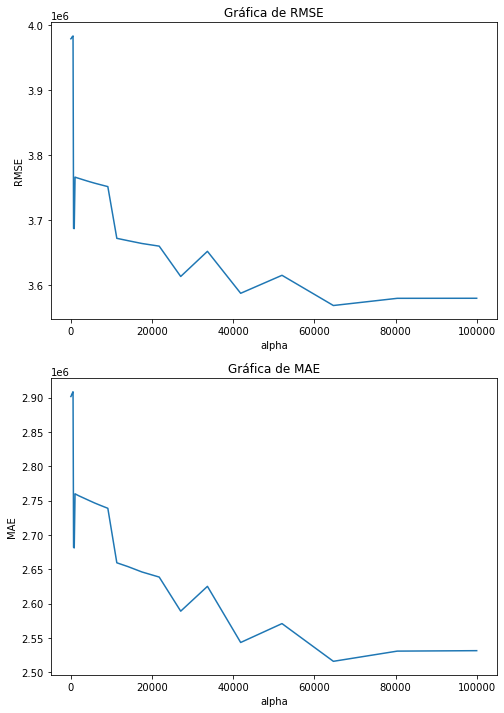

In [38]:
rmse = []
mae = []
rmse2 = []
mae2 = []

for i in np.logspace(-2, 5, 75): 
    model = Lasso(fit_intercept=True, tol=0.5, random_state=10, alpha = i)
    model.fit(X_train_5th_fold_train , y_train_5th_fold_train )
    y_pred = model.predict(X_test_5th_fold_train)
    rmse.append(np.sqrt(mean_squared_error(y_test_5th_fold_train , y_pred)))
    mae.append(mean_absolute_error(y_test_5th_fold_train, y_pred))
    

# Crear dos subplots, uno para cada gráfico
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))

# Graficar RMSE vs. n_neighbors en el primer subplot
ax1.plot(list(np.logspace(-2, 5, 75)), rmse, label="RMSE")
ax1.set_xlabel("alpha")
ax1.set_ylabel("RMSE")
ax1.set_title("Gráfica de RMSE")

# Graficar MAE vs. n_neighbors en el segundo subplot
ax2.plot(list(np.logspace(-2, 5, 75)), mae, label="MAE")
ax2.set_xlabel("alpha")
ax2.set_ylabel("MAE")
ax2.set_title("Gráfica de MAE")


# Mostrar los gráficos
plt.show()

#### 5.3.2.2. Linear Regression - Selected parameters - Attribute Selection

Results of the best estimator of Pipeline
NMAE in validation: -2389586.49
RMSE train: 3278341.47 | MAE train: 2333541.31
RMSE validation train: 3293274.52 | MAE validation train: 2336194.58
RMSE validation test: 3278610.61 | MAE validation test: 2258218.41


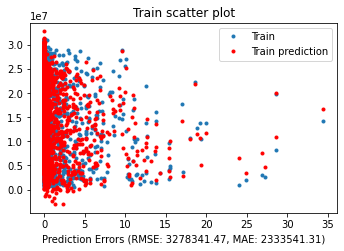

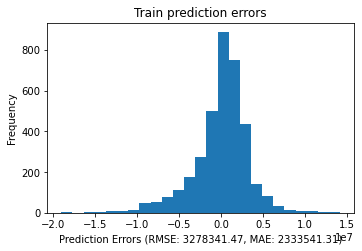

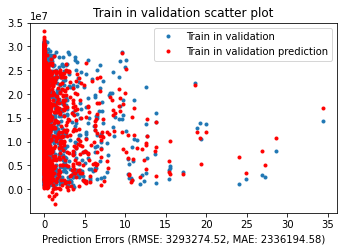

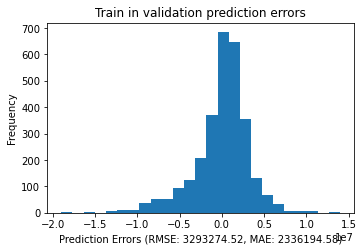

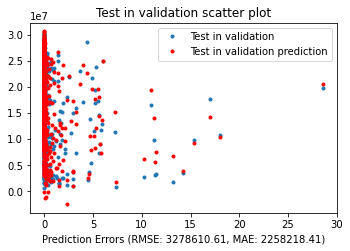

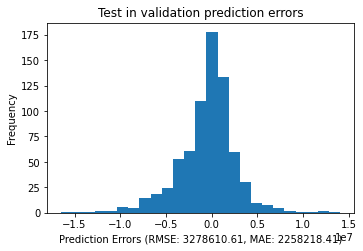

---------------------------------------------------
LINEAR REGRESSION SELECTED PARAMETERS best model is:

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                             ('model',
                                              Ridge(random_state=10))]),
                   n_iter=75, n_jobs=-1,
                   param_distributions={'model__alpha': array([ 0.01      ,  0.01097844,  0.01205261,  0.01323188,  0.01452654,
        0.01594787,  0.01750827,  0.01922135,  0.02110203,  0.02316674,
        0.025...
        0.66730492,  0.73259654,  0.80427655,  0.88297   ,  0.96936311,
        1.06420924,  1.16833549,  1.28264983,  1.40814912,  1.54592774,
        1.69718713,  1.86324631,  2.04555335,  2.245698  ,  2.46542555,
        2.70665207,  2.9714811 ,  3.26222201,  3.5814101 ,  3.93182876,
        4.31653369,  4.73887961,  5.20254944,  5.711

In [39]:
np.random.seed(10)
n_splits = 5

# We use Ridge as model as it is the best performing one
pipeline = Pipeline(
    [
        ("scaler", RobustScaler()),
        ("select", SelectKBest(f_regression)),
        ("model", Ridge(fit_intercept=True, random_state=10)),
    ]
)

# Previous model Parameters: {'model__alpha': 0.9693631061142517}

param_grid = {
    "model__alpha": [0.9693631061142517],
    "select__k": list(range(1, X_train.shape[1] + 1)),
}

# We use TimeSeriesSplit to split the data in folds without losing the temporal order
model = GridSearchCV(
    pipeline,
    param_grid,
    scoring="neg_mean_absolute_error",
    cv=TimeSeriesSplit(n_splits),
    n_jobs=-1,
)

start_time = time.time()
model.fit(X=X_train, y=y_train)
end_time = time.time()

total_time = end_time - start_time

# We calculate the subsets used for training and testing in the different folds of the cross-validation
# validation_splits(model, X_train)  # We al ready did the 5th fold split at the begginning

# We obtain the different scores of the model
score = train_validation_test(
    model,
    model.best_estimator_,
    model.best_score_,
    X_train,
    y_train,
)

models["LinearReg_select_k"] = model
results["LinearReg_select_k"] = score
times["LinearReg_select_k"] = total_time

# Print results
print_results("LINEAR REGRESSION SELECTED PARAMETERS", best_model, score, total_time)

To be observed, the selected model, Ridge, does not delete any of the attributes (as expected, as it is one of its flaws), but some of their weights are close to zero, so we can consider that they are not relevant for the model.

On the other hand, the Lasso model and the ElasticNet model, do delete some of the attributes, but the results are worse than the Ridge model, so we will not consider them.

## 5.4. Dummy Regressor

As in the other models, in order to be able to compare the different times and scores, we will divide the dummy regressor into two different models. The first model creates the model without selecting the attributes and the second uses the best parameters of the previous one and selects the attributes through another pipeline.

As strategy we selected "median" as we are dealing with (N)MAE as scoring in the other methods.

In [40]:
from sklearn.dummy import DummyRegressor

Results of the best estimator of Pipeline
NMAE in validation: -6953359.14
RMSE train: 8058570.05 | MAE train: 6899205.37
RMSE validation train: 8120616.17 | MAE validation train: 6944040.21
RMSE validation test: 7809144.90 | MAE validation test: 6720947.26


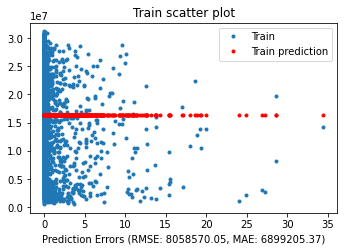

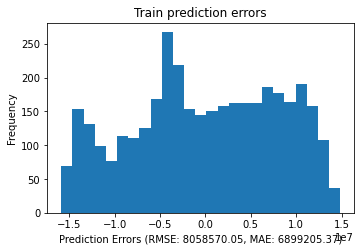

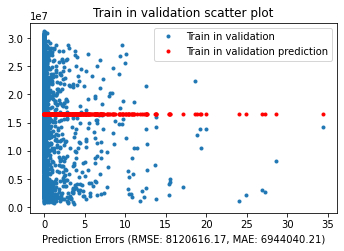

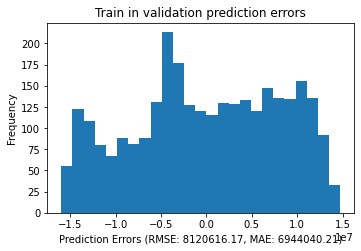

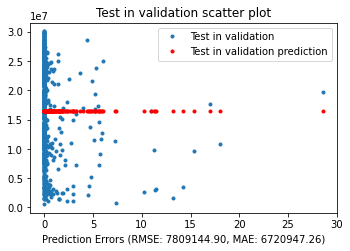

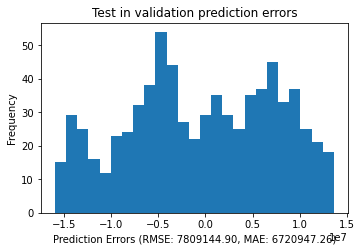

---------------------------------------------------
RANDOM FOREST PREDEFINED PARAMETERS best model is:

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('model', DummyRegressor())]),
             n_jobs=-1, param_grid={'model__strategy': ['median']},
             scoring='neg_mean_absolute_error')

Parameters: {'model__strategy': 'median'}

Performance: NMAE (val): -6953359.144736841 | RMSE train: 8058570.051086258 | MAE train: 6899205.369863014 | RMSE train in validation: 8120616.171716434 | MAE train in validation: 6944040.205479452 | RMSE test in validation: 7809144.902737563 | MAE test in validation: 6720947.2602739725
Execution time: 0.21776080131530762s


In [41]:
np.random.seed(10)
n_splits = 5

pipeline = Pipeline(
    [
        ("scaler", RobustScaler()),
        ("model", DummyRegressor()),
    ]
)

param_grid = {
    'model__strategy': ['median'],
}

model = GridSearchCV(
    pipeline,
    param_grid,
    scoring="neg_mean_absolute_error",
    cv=TimeSeriesSplit(n_splits),
    n_jobs=-1,
)

start_time = time.time()
model.fit(X=X_train, y=y_train)
end_time = time.time()

total_time = end_time - start_time

# We calculate the subsets used for training and testing in the different folds of the cross-validation
# validation_splits(model, X_train)  # We al ready did the 5th fold split at the begginning

# We obtain the different scores of the model
score = train_validation_test(
    model,
    model.best_estimator_,
    model.best_score_,
    X_train,
    y_train,
)

models["DummyReg"] = model
results["DummyReg"] = score
times["DummyReg"] = total_time

print_results("RANDOM FOREST PREDEFINED PARAMETERS", model, score, total_time)

### 5.4.2. Dummy Regressor - Attribute selection

Results of the best estimator of Pipeline
NMAE in validation: -6953359.14
RMSE train: 8058570.05 | MAE train: 6899205.37
RMSE validation train: 8120616.17 | MAE validation train: 6944040.21
RMSE validation test: 7809144.90 | MAE validation test: 6720947.26


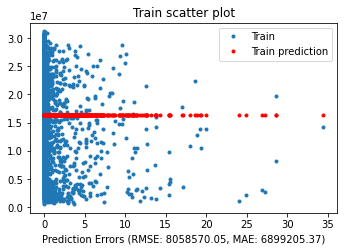

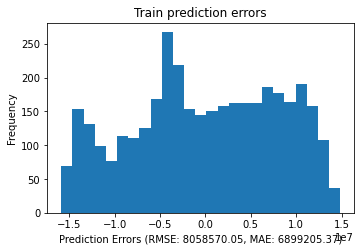

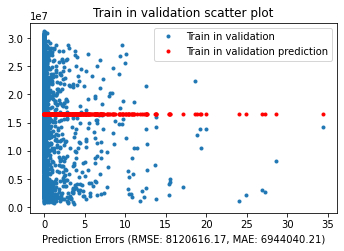

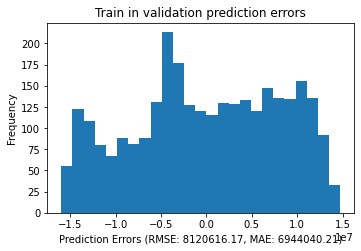

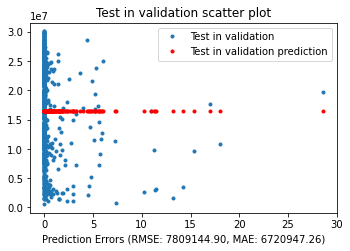

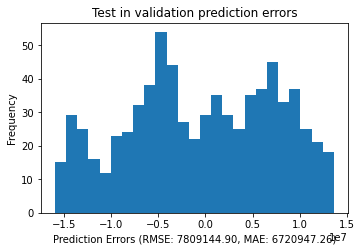

---------------------------------------------------
RANDOM FOREST PREDEFINED PARAMETERS best model is:

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('select',
                                        SelectKBest(score_func=<function f_regression at 0x0000022A9266B280>)),
                                       ('model',
                                        DummyRegressor(strategy='median'))]),
             n_jobs=-1,
             param_grid={'model__strategy': ['median'],
                         'select__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26, 27, 28, 29, 30, ...]},
             scoring='neg_mean_absolute_error')

Parameters: {'model__strategy': 'median', 'select__k': 1}

Performance: NMAE (val): -69

In [42]:
np.random.seed(10)
n_splits = 5

pipeline = Pipeline(
    [
        ("scaler", RobustScaler()),
        ("select", SelectKBest(f_regression)),
        ("model", DummyRegressor(strategy="median")),
    ]
)

# Previous model parameters: {'model__strategy': 'median'}

param_grid = {
    'model__strategy': ['median'],
    "select__k": list(range(1, X_train.shape[1] + 1)),
}

model = GridSearchCV(
    pipeline,
    param_grid,
    scoring="neg_mean_absolute_error",
    cv=TimeSeriesSplit(n_splits),
    n_jobs=-1,
)

start_time = time.time()
model.fit(X=X_train, y=y_train)
end_time = time.time()

total_time = end_time - start_time

# We calculate the subsets used for training and testing in the different folds of the cross-validation
# validation_splits(model, X_train)  # We al ready did the 5th fold split at the begginning

# We obtain the different scores of the model
score = train_validation_test(
    model,
    model.best_estimator_,
    model.best_score_,
    X_train,
    y_train,
)

models["DummyReg_k"] = model
results["DummyReg_k"] = score
times["DummyReg_k"] = total_time

print_results("RANDOM FOREST PREDEFINED PARAMETERS", model, score, total_time)

As expected, the selection of attributes does not improve the results of the dummy regressor model and it is useless in terms of performance. This is due to the fact that the dummy regressor is a model that does not take into account the attributes, so it does not matter if we select them or not, so it selects just one (k=1).

## 5.5. Results

First, we adjust the times by adding to the time of the selection of the attributes the time of training the real model. This is because the selection of the attributes is done after the training of the model, so it does not contain the time of the training of the model.<br><br>This is just an approximation to how much the selection of the attributes will last, as we are using two different models and pipelines, we are not able to calculate it directly.

In [43]:
# We store the partial times for future use
partial_times = times.copy()

# Real time adjustment (we add the time of the attribute selection to the time of the model real training)
print(times)
for key in times.keys():
    # If even, we dont add the time of the attribute selection
    # If odd, we add the time of the attribute selection
    if list(times.keys()).index(key) % 2 != 0:
        times[key] += times[key.replace("_k", "")]
print(times)

{'KNN_pred': 4.498199224472046, 'KNN_pred_k': 4.498199224472046, 'KNN_select': 5.945904493331909, 'KNN_select_k': 4.205214738845825, 'RegTrees_pred': 0.5906541347503662, 'RegTrees_pred_k': 3.4071078300476074, 'RegTrees_select': 16.696850776672363, 'RegTrees_select_k': 28.325833797454834, 'LinearReg_pred': 0.26170992851257324, 'LinearReg_pred_k': 1.8227741718292236, 'LinearReg_select': 3.960240125656128, 'LinearReg_select_k': 1.7129440307617188, 'DummyReg': 0.21776080131530762, 'DummyReg_k': 1.6625022888183594}
{'KNN_pred': 4.498199224472046, 'KNN_pred_k': 8.996398448944092, 'KNN_select': 5.945904493331909, 'KNN_select_k': 10.151119232177734, 'RegTrees_pred': 0.5906541347503662, 'RegTrees_pred_k': 3.9977619647979736, 'RegTrees_select': 16.696850776672363, 'RegTrees_select_k': 45.0226845741272, 'LinearReg_pred': 0.26170992851257324, 'LinearReg_pred_k': 2.084484100341797, 'LinearReg_select': 3.960240125656128, 'LinearReg_select_k': 5.673184156417847, 'DummyReg': 0.21776080131530762, 'Dumm

In [44]:
np.random.seed(10)

# ! Obtain best, worst, fastest and slowest model
max_score = max(results.values(), key=lambda x: abs(x[0]))  # We use the scoring (NMAE) as explained above to select the best model
min_score = min(results.values(), key=lambda x: abs(x[0]))
# Obtain the key name of the best and worst model
max_time = max(times.values(), key=lambda x: x)
min_time = min(times.values(), key=lambda x: x)

best_model = list(results.keys())[list(results.values()).index(min_score)]
worst_model = list(results.keys())[list(results.values()).index(max_score)]
fastest_model = list(times.keys())[list(times.values()).index(min_time)]
slowest_model = list(times.keys())[list(times.values()).index(max_time)]

print(f"Best model: {best_model} with score (-NMAE) {abs(min_score[0])} and time {list(times.values())[list(results.values()).index(min_score)]}s")
print(f"Worst model: {worst_model} with score (-NMAE) {abs(max_score[0])} and time {list(times.values())[list(results.values()).index(max_score)]}s")
print(f"Fastest model: {fastest_model} with score (-NMAE) {abs(results[fastest_model][0])} and time {min_time}s")
print(f"Slowest model: {slowest_model} with score(-NMAE) {abs(results[slowest_model][0])} and time {max_time}s")


# ! Average (test MAE) score of the models
avg_score = 0
avg_time = 0

for key, value in results.items():
    avg_score += results[key][0]
    avg_time += times[key]

print(f"\nAverage models score: {abs(avg_score/len(results))}")
print(f"Average models time: {avg_time/len(times)}\n")


# ! Differences
print("The score difference between the best and worst model is: ", abs(max_score[0] - min_score)[0])  # Scoring evaluation -NMAE
print("The score difference between the best and fastest model is: ", abs(min_score[0] - abs(results[fastest_model][0])))  # Scoring evaluation -NMAE
print("The time difference between the best and fastest model model is: ", abs(list(times.values())[list(results.values()).index(min_score)] - min_time))
print("The time difference between the fastest and slowest model is: ", abs(max_time - min_time))

Best model: LinearReg_select_k with score (-NMAE) 2389586.491181177 and time 5.673184156417847s
Worst model: DummyReg with score (-NMAE) 6953359.144736841 and time 0.21776080131530762s
Fastest model: DummyReg with score (-NMAE) 6953359.144736841 and time 0.21776080131530762s
Slowest model: RegTrees_select_k with score(-NMAE) 2727416.151315789 and time 45.0226845741272s

Average models score: 3373778.2092190557
Average models time: 7.855515360832214

The score difference between the best and worst model is:  4563772.653555664
The score difference between the best and fastest model is:  9342945.635918017
The time difference between the best and fastest model model is:  5.455423355102539
The time difference between the fastest and slowest model is:  44.80492377281189


MODEL SCORES (NMAE in evaluation)
0. KNN_pred: 3239984.25
1. KNN_pred_k: 2690780.4078947366
2. KNN_select: 2880131.5631625694
3. KNN_select_k: 2603870.865432223
4. RegTrees_pred: 3467149.4407894737
5. RegTrees_pred_k: 3328832.171052632
6. RegTrees_select: 2743220.575657895
7. RegTrees_select_k: 2727416.151315789
8. LinearReg_pred: 2437056.0592061607
9. LinearReg_pred_k: 2421796.652193799
10. LinearReg_select: 2396352.0117066414
11. LinearReg_select_k: 2389586.491181177
12. DummyReg: 6953359.144736841
13. DummyReg_k: 6953359.144736841


FileNotFoundError: [Errno 2] No such file or directory: '../data/img/basic_methods_score.png'

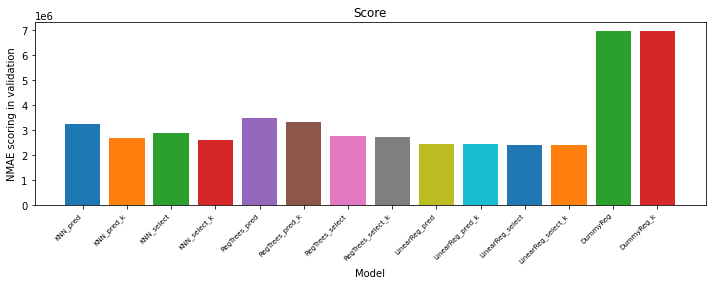

In [45]:
# Print the results up to now
plt.rcParams['figure.figsize'] = [10, 3.5]

# ! Plot the scores (NMAE in evaluation)
print("MODEL SCORES (NMAE in evaluation)")
iter = 0
for key, value in results.items():
    plt.bar(key, abs(value[0]))
    print(f"{iter}. {key}: {abs(value[0])}")
    iter += 1
plt.title("Score")
plt.xlabel("Model")
plt.ylabel("NMAE scoring in validation")
plt.tight_layout()

plt.xticks(rotation=45, ha='right', size=7)

# Exporting image as png to ../data/img folder
plt.savefig("../data/img/basic_methods_score.png")
plt.show()

# ! Plot the time (just the even ones == the ones that are not selectors of attributes)
print("MODEL TIMES (s)")
iter = 0
for key, value in times.items():
    if iter % 2 == 0:
        plt.bar(key, value)
        print(f"{iter}. {key}: {value}")
    iter += 1
plt.title("Time")
plt.xlabel("Model")
plt.ylabel("Time (s)")
plt.tight_layout()

plt.xticks(rotation=45, ha='right', size=7)

# Exporting image as png to ../data/img folder
plt.savefig("../data/img/basic_methods_time.png")
plt.show()

# ! Plot the time (just the odd ones == the selectors of attributes)
print("MODEL ATTRIBUTE SELECTION TIMES (s)")
iter = 0
for key, value in times.items():
    if iter % 2 != 0:
        plt.bar(key, value)
        print(f"{iter}. {key}: {value}")
    iter += 1
plt.title("Time to select attributes")
plt.xlabel("Model")
plt.ylabel("Time (s)")
plt.tight_layout()

plt.xticks(rotation=45, ha='right', size=7)

# Exporting image as png to ../data/img folder - easier to visualize the annotations, better resolution
plt.savefig("../data/img/basic_methods_time_atb.png")
plt.show()

## 5.6. Conclusions: 

After computing all of the models, we can draw some conclusions:

- **Best model**: the best model in terms of scoring (-NMAE) is the LinearReg_select_k (linear regression with selected parameters and selected attributes) model, with a score of 2389586.491181177
- **Fastest model**: the fastest model is the dummy regressor, as it does not need to train the model, it just returns the median of the target variable.
- **Fastest Basic model**: the fastest basic model is the Linear Regression with predefined parameters, as it does not need to select attributes. Surprisingly, it is pretty accurate as well (linear regression models work pretty well out of the box without needing parameter selection), having a score 2437056.0592061607 near to the one obtained by the Linear Regression with selected parameters and attribute selection.

**¿Are the obtained results better than the ones from the naive approach?**

Yes, they are, all of the models had a way better score than the one obtained by the naive approach, which had an -NMAE of 6953359.144736841 (with and without attribute selection). This can be clearly seen in the first graph showing the different models and their scores.<br>
There, it can be observed that all of the models we tested outperformed the dummy model by a significant margin. The dummy model produced an NMAE error of -6953359.144736841, while our worst-performing model (RegTrees_pred) produced an error of -3467149.4407894737.

**¿Are models with selection of parameters better than the ones that use the predefined ones?**

We found that in general, selecting hyperparameters led to better results across all of the models. However, this improvement came at the cost of increased time and computing resources. Therefore, when deciding which model to use, it is important to consider the balance between improved performance and increased training time.


**¿Are models with selection of attributes better than the ones that use all of them?**

By observing the performace (both time and score), and the graphs, we can observe that the models with attribute selection generally perform better than those that use all attributes as they help reduce noise and irrelevant features, resulting in a more focused set of attributes for modeling, improving accuracy and generalization. However, as it can be observed in the third graph, attribute selection  increases computation time as it adds a stage of preprocessing to the model. Despite the longer training times, the benefits of improved performance may outweigh the costs. As stated with selection of parameters question, it is needed to consider specific project requirements and resources when deciding on the approach to use.


**Model selection**

Regarding the individual models, we observed that the LinearReg_select_k model performed the best in terms of NMAE, while the RegTrees_pred model performed the worst, as it overfits perfectly the training data.

Based on these findings, we would recommend using the LinearReg_select_k model (-NMAE: 2389586.491181177; time: 4.264322519302368) if the client prioritizes accuracy over computing time. However, if computing time is a priority, we would recommend using the LinearReg_pred model (-NMAE: 2437056.0592061607; time: 0.23032045364379883), which only sacrifices about 47470 points of accuracy points (1.95%) while reducing computing time by more than 94.2%.

On the other hand, if we wanted a balance in between those two models, there are LinearReg_pred_k (-NMAE: 2421796.652193799; time: 2.2443368434906006) and LinearReg_select (-NMAE: 2396352.0117066414; time: 2.5291051864624023), which are a good balance between accuracy and computing time.

Ultimately, the decision of which model to use depends on the client's budget and objectives. For the final prediction, we recommend using the LinearReg_select_k (or LinearReg_select) model as it still provides a good balance between accuracy and computing time. Moreover, taking into account the dataset and the problem nature, it is plausible that the model training will be done at much yearly, so the time saved by using the LinearReg_pred instead of the LinearReg_pred_k model is not significant compared to the score gained.

---
# 6. Reducing Dimensionality

It is possible to reduce the problem's dimensionality, as evidenced by the findings in the EDA section, where numerous attributes were identified to be highly correlated. By removing some of these attributes, we can effectively reduce the dimensionality of the problem. Therefore, it is recommended to utilize Principal Component Analysis (PCA) as a technique to reduce the dimensionality of the problem.

As highlighted in the EDA section, there are several attributes that exhibit strong interrelationships to the point of being redundant (with a correlation higher than 98%).

There are **two different approaches to reduce the dimensionality** of the problem:

- The **first one** was **removing by hand** the attributes seen as redundant in the EDA section. This approach was not used as it would be a tedious and error-prone process, and it would not be scalable to other datasets.

- The **second** approach, which is the one used in the industry, is to **use a feature selection** algorithm preprocessing in the pipeline of the models to automatically identify and remove redundant attributes.

This second approach of using pipelines with attribute selection was the one employed in our project. It was implemented using the "SelectKBest(f_regression)" feature selector, which considers only the linear relationship between the attributes and the output variable. As consecuence, using this feature selector leaves room to more possible optimisations and selections of correlated relationships of non-linear nature or interrelationships between the attributes, as seen in the EDA section. Therefore, there is still a space to improve the results by using a more advanced feature selection algorithm, such as the "Recursive Feature Elimination" algorithm (RFE).

KNN_pred_k selected 6
KNN_select_k selected 6
RegTrees_pred_k selected 9
RegTrees_select_k selected 4
LinearReg_pred_k selected 72
LinearReg_select_k selected 72
DummyReg_k selected 1
Attributes frequency: {'apcp_sf1_1': 2, 'apcp_sf2_1': 2, 'apcp_sf3_1': 2, 'apcp_sf4_1': 2, 'apcp_sf5_1': 2, 'dlwrf_s1_1': 2, 'dlwrf_s2_1': 2, 'dlwrf_s3_1': 2, 'dlwrf_s4_1': 2, 'dlwrf_s5_1': 2, 'dswrf_s1_1': 2, 'dswrf_s2_1': 5, 'dswrf_s3_1': 7, 'dswrf_s4_1': 6, 'dswrf_s5_1': 6, 'pres_ms1_1': 0, 'pres_ms2_1': 0, 'pres_ms3_1': 0, 'pres_ms4_1': 2, 'pres_ms5_1': 2, 'pwat_ea1_1': 2, 'pwat_ea2_1': 2, 'pwat_ea3_1': 2, 'pwat_ea4_1': 2, 'pwat_ea5_1': 2, 'spfh_2m1_1': 2, 'spfh_2m2_1': 2, 'spfh_2m3_1': 2, 'spfh_2m4_1': 2, 'spfh_2m5_1': 2, 'tcdc_ea1_1': 2, 'tcdc_ea2_1': 2, 'tcdc_ea3_1': 2, 'tcdc_ea4_1': 2, 'tcdc_ea5_1': 2, 'tcolc_e1_1': 2, 'tcolc_e2_1': 2, 'tcolc_e3_1': 2, 'tcolc_e4_1': 2, 'tcolc_e5_1': 2, 'tmax_2m1_1': 2, 'tmax_2m2_1': 2, 'tmax_2m3_1': 2, 'tmax_2m4_1': 2, 'tmax_2m5_1': 2, 'tmin_2m1_1': 2, 'tmin_2m2_1

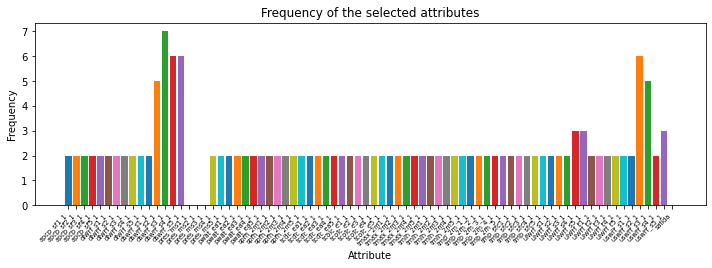

In [ ]:
# Create a dictionary with all the dataset variables
def get_variable_freq():
    columns = disp_df.columns.tolist()
    variables = {col: 0 for col in columns}

    # Getting the selected attributes for each model
    for model in models.keys():
        # We only want to check the models that select attributes (take into account that dummy regressor selection is included(dswrf_s3_1))
        if list(models.keys()).index(model) % 2 != 0:
            # We get the selected attributes
            selected_atb = models[model].best_estimator_.named_steps["select"].get_support()
            # We get the names of the selected attributes
            selected_atb_names = X_train.columns[selected_atb]
            
            print(f"{model} selected {len(selected_atb_names)}")
            
            # Make a frequency table of the selected attributes
            selected_atb_names = pd.DataFrame(selected_atb_names)
            selected_atb_names.columns = ["Attribute"]
            selected_atb_names = selected_atb_names.groupby("Attribute").size().reset_index(name="Frequency")
            selected_atb_names = selected_atb_names.sort_values(by="Frequency", ascending=False)
            selected_atb_names = selected_atb_names.reset_index(drop=True)
            
            # Append the results the dictionary
            for atb in selected_atb_names["Attribute"]:
                variables[atb] += 1

    print(f"Attributes frequency: {variables}")

    # plot all the attributes and their frequency
    plt.rcParams['figure.figsize'] = [10, 3.5]

    for key, value in variables.items():
        plt.bar(key, value)

    plt.title("Frequency of the selected attributes")
    plt.xlabel("Attribute")
    plt.ylabel("Frequency")
    plt.tight_layout()

    plt.xticks(rotation=45, ha='right', size=6.5)
    plt.show()

get_variable_freq()

Upon analyzing the graph, we gain valuable insights into the attributes that are frequently selected by the feature selector like *dswrf_s2_1*, *dswrf_s3_1*, *dswrf_s4_1*, *dswrf_s5_1*, *uswrf_s2_1*, and *uswrf_s3_1*. It is evident that the attributes chosen are highly correlated with the target variable, aligning with our expectations. This reaffirms the efficacy of the feature selector in identifying relevant attributes correlated to the target variable.<br>Take into account that some of the mentioned attributes are also highly correlated with each other (as seen during EDA), but this is not a problem that our feature selector is able to identify.

Conversely, we can also infer that attributes that are scarcely selected by the feature selector, such as *pres_ms1_1*, *pres_ms2_1*, and *pres_ms3_1*, are not significant in the context of the problem. This is indicative that these attributes lack correlation with the target variable, and their inclusion in the model may introduce noise or irrelevant information. Hence, the feature selector's ability to filter out such attributes further strengthens its effectiveness in feature selection and highlights the importance of using it for improved model performance.

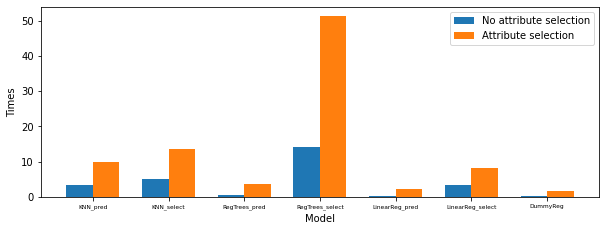

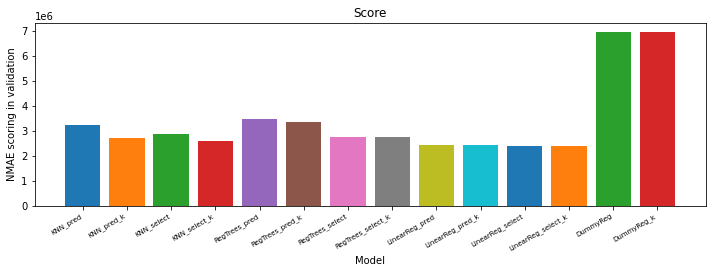

In [ ]:
plt.rcParams['figure.figsize'] = [10, 3.5]

# Select the even times (the ones that are not selectors of attributes)
times_no_atb = {k: v for k, v in times.items() if list(times.keys()).index(k) % 2 == 0}
# Select the odd times (the ones that are selectors of attributes)
times_atb = {k: v for k, v in times.items() if list(times.keys()).index(k) % 2 != 0}

# Sum both dictionaries to get the total time of each model
for key in times_atb.keys():
    times_atb[key] += times_no_atb[key.replace("_k", "")]

times_no_atb_arr = list(times_no_atb.values())
times_atb_arr = list(times_atb.values())

model_indices = np.arange(len(list(times_no_atb.keys())))

width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(model_indices - width/2, times_no_atb_arr, width, label='No attribute selection')
rects2 = ax.bar(model_indices + width/2, times_atb_arr, width, label='Attribute selection')

ax.set_xlabel('Model')
ax.set_ylabel('Times')
ax.set_title('')
ax.set_xticks(model_indices)
ax.set_xticklabels(list(times_no_atb.keys()))
ax.legend()

plt.xticks(size=5.9)
plt.show()


iter = 0
for key, value in results.items():
    plt.bar(key, abs(value[0]))
    iter += 1
plt.title("Score")
plt.xlabel("Model")
plt.ylabel("NMAE scoring in validation")
plt.tight_layout()

plt.xticks(rotation=30, ha='right', size=7)
plt.show()

As mentioned in the "Conclusions" section (Section 5.6), the performance of the models with attribute selection is generally better compared to using all attributes. This is because attribute selection helps reduce noise and irrelevant features, resulting in a more focused set of attributes for modeling, which can lead to improved accuracy and generalization, as evident from the performance metrics and graphs. However, it should be noted that attribute selection does add an additional preprocessing stage to the model, which can increase computation time. Despite the longer training times, the potential benefits of improved performance may outweigh the costs.

The performance of the models with and without attribute selection is clearly depicted in the two above graphs:

- The first graph illustrates that the models with attribute selection require more computing time compared to those using all attributes. This is expected due to the additional preprocessing stage.

- The second graph demonstrates how the models with attribute selection outperform those using all attributes, as they effectively reduce noise and irrelevant features, resulting in improved performance.

---
# 7. Advanced methods

In order to be consistent, although we have already seen that usign the selection of attributes makes the model better, we will continue to use the two-step pipeline method we have been using in the basic models. This way, we can also verify that the results are better than the ones obtained with the basic methods (for both with and without attribute selection).

## 7.1. Support Vector Machines (SVMs)

Support Vector Machine (SVM) is a supervised learning algorithm used for classification and regression analysis. SVM works by finding the hyperplane that best separates the data into different classes. The hyperplane is chosen such that it maximizes the margin between the closest data points from each class, known as support vectors. SVM can also use kernel functions to transform the input data into a higher dimensional space, allowing the separation of non-linearly separable data.

Note: in this dataset, the target variable conatains very large values, and the default value of C is 1.0 by default, which is too small for this dataset. This will make the SVM act as if it was a dummy regressor (as seen before), where it simply predicts the mean of the target variable for all data points, leading to poor model performance. This can be readily observed in section 8 of the notebook, where we compare the values and results of all the models, including the computation time and score. Notably, we find that the results of the Support Vector Machine (SVM) model with the default value of C are identical to those of the dummy regressor.

To overcome this issue, it is important to select an appropriate value for the C parameter that matches the characteristics of the dataset. By increasing the value of C to a more suitable value, the SVM becomes more flexible and capable of fitting the data better. This allows the SVM to capture the underlying patterns and relationships in the dataset more accurately, resulting in improved prediction performance.

In [ ]:
from sklearn.svm import SVR

### 7.1.1. SVMs - Predefined parameters

#### 7.1.1.1. SVMs - Predefined parameters - No attribute selection

Results of the best estimator of Pipeline
NMAE in validation: -6953343.12
RMSE train: 8058525.28 | MAE train: 6899170.65
RMSE validation train: 8120576.93 | MAE validation train: 6944009.69
RMSE validation test: 7809107.04 | MAE validation test: 6720917.54


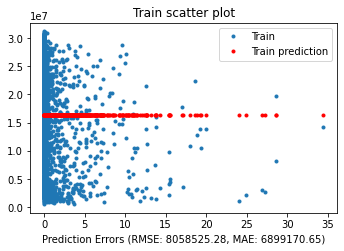

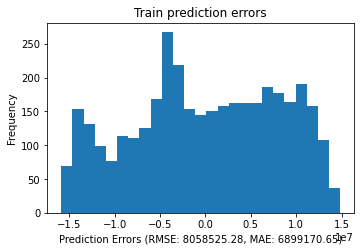

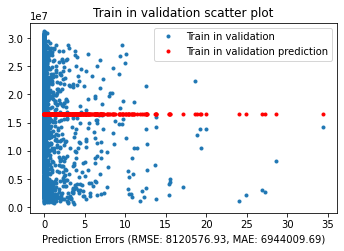

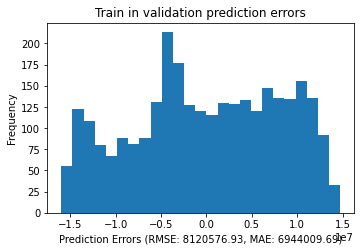

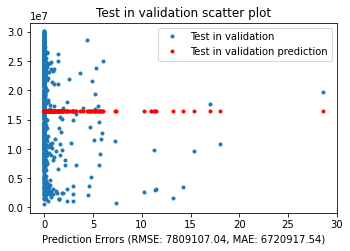

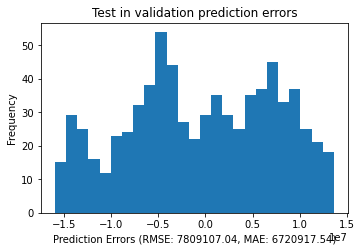

---------------------------------------------------
SVM PREDEFINED PARAMETERS best model is:

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('model', SVR())]),
             param_grid={'model__C': [1.0], 'model__epsilon': [0.1],
                         'model__gamma': ['scale'], 'model__kernel': ['rbf']},
             scoring='neg_mean_absolute_error')

Parameters: {'model__C': 1.0, 'model__epsilon': 0.1, 'model__gamma': 'scale', 'model__kernel': 'rbf'}

Performance: NMAE (val): -6953343.117286754 | RMSE train: 8058525.276321875 | MAE train: 6899170.647284467 | RMSE train in validation: 8120576.9337218935 | MAE train in validation: 6944009.686073507 | RMSE test in validation: 7809107.037449846 | MAE test in validation: 6720917.536373118
Execution time: 3.174482822418213s


In [ ]:
np.random.seed(10)
n_splits = 5

pipeline = Pipeline(
    [
        ('scaler', RobustScaler()),
        ("model", SVR())
    ]
)

param_grid = {
    "model__kernel": ["rbf"],
    "model__C": [1.0],
    "model__gamma": ["scale"],
    "model__epsilon": [0.1],
}

model = GridSearchCV(
    pipeline,
    param_grid,
    scoring="neg_mean_absolute_error",
    cv=TimeSeriesSplit(n_splits),
)


start_time = time.time()
model.fit(X=X_train, y=y_train)
end_time = time.time()

total_time = end_time - start_time

# We calculate the subsets used for training and testing in the different folds of the cross-validation
# validation_splits(model, X_train)  # We al ready did the 5th fold split at the begginning

# We obtain the different scores of the model
score = train_validation_test(
    model,
    model.best_estimator_,
    model.best_score_,
    X_train,
    y_train,
)

models["SVM_pred"] = model
results["SVM_pred"] = score
times["SVM_pred"] = total_time

print_results("SVM PREDEFINED PARAMETERS", model, score, total_time)

As it was stated before, it can be clearly seen that with the default 1.0 value of C, the SVM acts as a dummy regressor.

#### 7.1.1.2. SVMs - Predefined parameters - Attribute selection

Results of the best estimator of Pipeline
NMAE in validation: -6952999.55
RMSE train: 8057851.47 | MAE train: 6898491.59
RMSE validation train: 8120039.58 | MAE validation train: 6943474.80
RMSE validation test: 7808606.98 | MAE validation test: 6720375.02


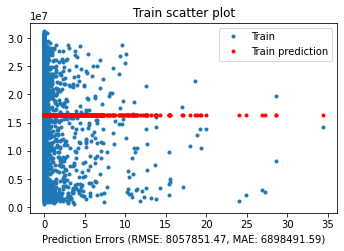

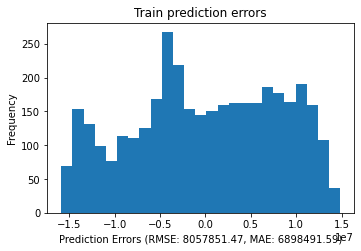

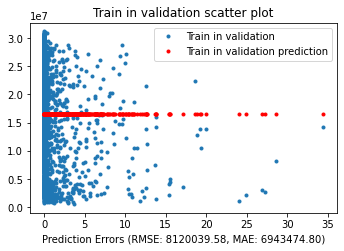

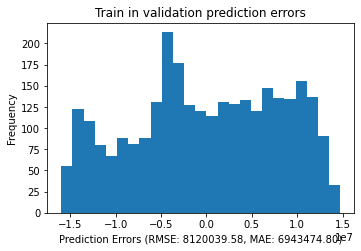

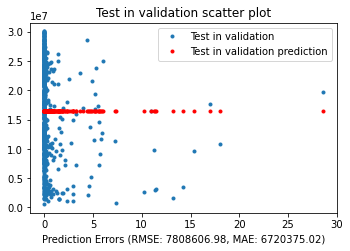

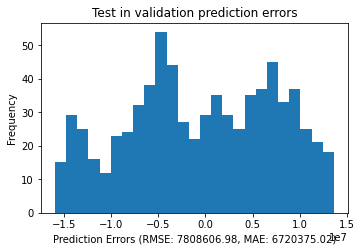

---------------------------------------------------
SVM PREDEFINED PARAMETERS best model is:

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('select',
                                        SelectKBest(score_func=<function f_regression at 0x00000219AFF92EE0>)),
                                       ('model', SVR())]),
             n_jobs=-1,
             param_grid={'model__C': [1.0], 'model__epsilon': [0.1],
                         'model__gamma': ['scale'], 'model__kernel': ['rbf'],
                         'select__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26, 27, 28, 29, 30, ...]},
             scoring='neg_mean_absolute_error')

Parameters: {'model__C': 1.0, 'model__epsilon': 0.1, 'model__gamma': 'scal

In [ ]:
np.random.seed(10)
n_splits = 5

pipeline = Pipeline(
    [
        ("scaler", RobustScaler()),
        ("select", SelectKBest(f_regression)),
        ("model", SVR()),
    ]
)

param_grid = {
    "model__kernel": ["rbf"],
    "model__C": [1.0],
    "model__gamma": ["scale"],
    "model__epsilon": [0.1],
    "select__k": list(range(1, X_train.shape[1] + 1)),
}

model = GridSearchCV(
    pipeline,
    param_grid,
    scoring="neg_mean_absolute_error",
    cv=TimeSeriesSplit(n_splits),
    n_jobs=-1,
)


start_time = time.time()
model.fit(X=X_train, y=y_train)
end_time = time.time()

total_time = end_time - start_time

# We calculate the subsets used for training and testing in the different folds of the cross-validation
# validation_splits(model, X_train)  # We al ready did the 5th fold split at the begginning

# We obtain the different scores of the model
score = train_validation_test(
    model,
    model.best_estimator_,
    model.best_score_,
    X_train,
    y_train,
)

models["SVM_pred_k"] = model
results["SVM_pred_k"] = score
times["SVM_pred_k"] = total_time

print_results("SVM PREDEFINED PARAMETERS", model, score, total_time)

### 7.1.2. SVMs - Selected parameters

Building upon the previous definition, we can reduce the most important parameters to be adjusted to the following for SVM:

- Kernel: This parameter defines the type of kernel used to transform the input data into a higher-dimensional space in order to perform classification. The most commonly used kernels are linear, polynomial, radial basis function (RBF), and sigmoid.
- C: This parameter determines the trade-off between maximizing the margin and minimizing the classification error. A smaller value of C creates a larger margin but may misclassify some data points, while a larger value of C may lead to overfitting.
- Gamma: This parameter defines the influence of each training example on the decision boundary. A smaller value of gamma makes the decision boundary smoother, while a larger value of gamma makes it more complex and can lead to overfitting.

#### 7.1.2.1. SVMs - Selected parameters - No attribute selection

Note: we needed to add more parameters to C in order to have a budget of 75 so it is comparable to the other models.

Results of the best estimator of Pipeline
NMAE in validation: -2331297.20
RMSE train: 3390722.81 | MAE train: 2254336.08
RMSE validation train: 3402804.08 | MAE validation train: 2244918.83
RMSE validation test: 3486393.92 | MAE validation test: 2328968.77


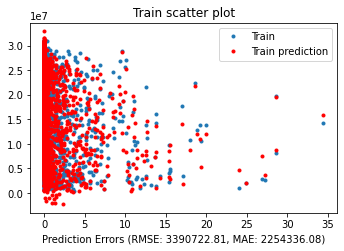

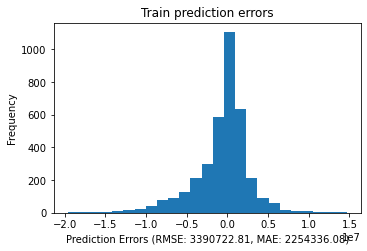

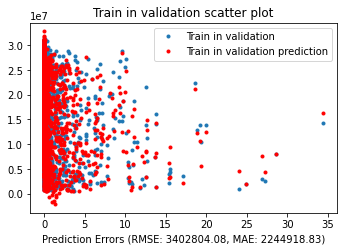

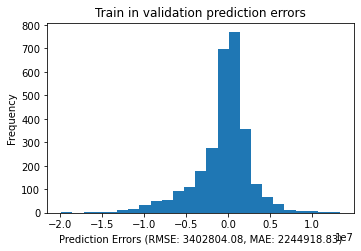

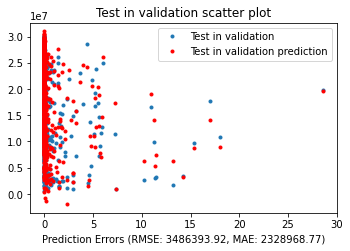

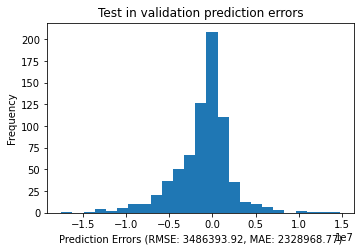

---------------------------------------------------
SVM SELECTED PARAMETERS best model is:

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('model', SVR())]),
                   n_iter=75, n_jobs=-1,
                   param_distributions={'model__C': [500000, 5000000, 7000000,
                                                     750000, 7750000, 800000,
                                                     8500000, 1000000, 2500000,
                                                     5000000],
                                        'model__gamma': ['scale', 'auto'],
                                        'model__kernel': ['linear', 'rbf',
                                                          'sigmoid', 'poly']},
                   scoring='neg_mean_absolute_error')

Parameters: {'model__kernel': 'linear', 'model__

In [ ]:
np.random.seed(10)
budget = 75 # Accepts 40 at most
n_splits = 5

pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        # We scale the data to avoid overfitting - Recommended for SVMs
        ("model", SVR())
        # Support Vector Regression (SVR for regression, SVC for classification)
    ]
)

param_grid = {
    "model__kernel": ["linear", "rbf", "sigmoid", "poly"], # poly is too slow and not near good as linear
    "model__C": [500000, 5000000, 7000000, 750000, 7750000, 800000, 8500000, 1000000, 2500000, 5000000],
    "model__gamma": ["scale", "auto"],
}

# We use TimeSeriesSplit to split the data in folds without losing the temporal order
model = RandomizedSearchCV(
    pipeline,
    param_grid,
    scoring="neg_mean_absolute_error",
    cv=TimeSeriesSplit(n_splits),
    n_iter=budget,
    n_jobs=-1,
)

start_time = time.time()
model.fit(X=X_train, y=y_train)
end_time = time.time()

total_time = end_time - start_time

# We calculate the subsets used for training and testing in the different folds of the cross-validation
# validation_splits(model, X_train)  # We al ready did the 5th fold split at the begginning

# We obtain the different scores of the model
score = train_validation_test(
    model,
    model.best_estimator_,
    model.best_score_,
    X_train,
    y_train,
)

models["SVM_select"] = model
results["SVM_select"] = score
times["SVM_select"] = total_time

print_results("SVM SELECTED PARAMETERS", model, score, total_time)

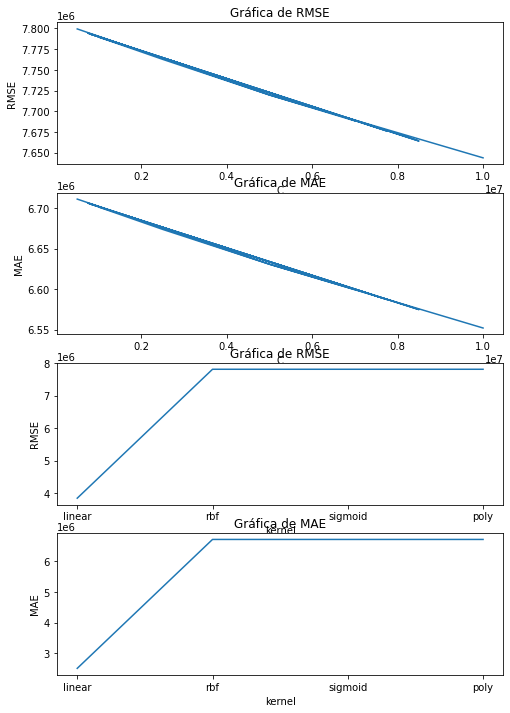

In [ ]:
rmse = []
mae = []
rmse2 = []
mae2 = []

for i in [500000, 5000000, 7000000, 750000, 7750000, 800000, 8500000, 1000000, 2500000, 5000000]: 
    model = SVR(C=i)
    model.fit(X_train_5th_fold_train , y_train_5th_fold_train )
    y_pred = model.predict(X_test_5th_fold_train)
    rmse.append(np.sqrt(mean_squared_error(y_test_5th_fold_train , y_pred)))
    mae.append(mean_absolute_error(y_test_5th_fold_train, y_pred))
    
for i in ["linear", "rbf", "sigmoid", "poly"]:
    model = SVR(kernel=i)
    model.fit(X_train_5th_fold_train , y_train_5th_fold_train )
    y_pred = model.predict(X_test_5th_fold_train)
    rmse2.append(np.sqrt(mean_squared_error(y_test_5th_fold_train , y_pred)))
    mae2.append(mean_absolute_error(y_test_5th_fold_train, y_pred))

# Crear dos subplots, uno para cada gráfico
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(8, 12))

# Graficar RMSE vs. n_neighbors en el primer subplot
ax1.plot([500000, 5000000, 7000000, 750000, 7750000, 800000, 8500000, 1000000, 2500000, 5000000], rmse, label="RMSE")
ax1.set_xlabel("C")
ax1.set_ylabel("RMSE")
ax1.set_title("Gráfica de RMSE")

# Graficar MAE vs. n_neighbors en el segundo subplot
ax2.plot([500000, 5000000, 7000000, 750000, 7750000, 800000, 8500000, 1000000, 2500000, 5000000], mae, label="MAE")
ax2.set_xlabel("C")
ax2.set_ylabel("MAE")
ax2.set_title("Gráfica de MAE")

# Graficar RMSE vs. metric en el tercer subplot
ax3.plot(["linear", "rbf", "sigmoid", "poly"], rmse2, label="RMSE")
ax3.set_xlabel("kernel")
ax3.set_ylabel("RMSE")
ax3.set_title("Gráfica de RMSE")

# Graficar MAE vs. metric en el cuarto subplot
ax4.plot(["linear", "rbf", "sigmoid", "poly"], mae2, label="MAE")
ax4.set_xlabel("kernel")
ax4.set_ylabel("MAE")
ax4.set_title("Gráfica de MAE")

# Mostrar los gráficos
plt.show()

Results of the best estimator of Pipeline
NMAE in validation: -2328373.33
RMSE train: 3424160.74 | MAE train: 2272228.45
RMSE validation train: 3456281.87 | MAE validation train: 2273860.91
RMSE validation test: 3576814.24 | MAE validation test: 2379560.79


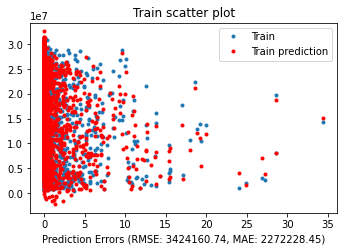

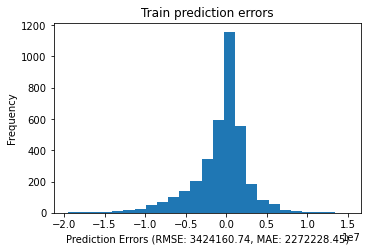

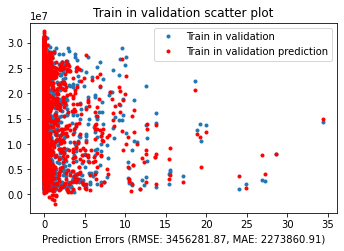

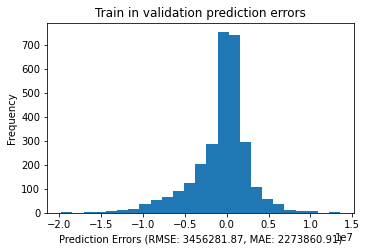

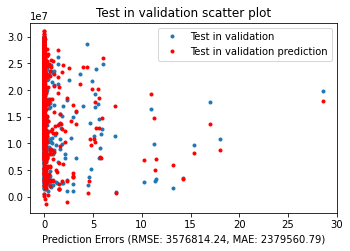

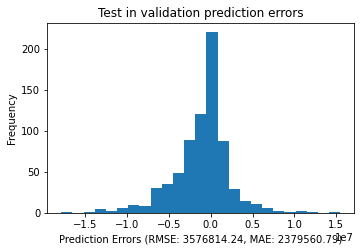

---------------------------------------------------
SVM SELECTED PARAMETERS best model is:

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('select',
                                        SelectKBest(score_func=<function f_regression at 0x00000219AFF92EE0>)),
                                       ('model', SVR())]),
             n_jobs=-1,
             param_grid={'model__C': [800000], 'model__gamma': ['auto'],
                         'model__kernel': ['linear'],
                         'select__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26, 27, 28, 29, 30, ...]},
             scoring='neg_mean_absolute_error')

Parameters: {'model__C': 800000, 'model__gamma': 'auto', 'model__kernel': 'linear', 'select__k

In [ ]:
np.random.seed(10)
n_splits = 5

# We use Ridge as model as it is the best performing one
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("select", SelectKBest(f_regression)),
        ("model", SVR())
    ]
)

# Previous model Parameters: {'model__kernel': 'linear', 'model__gamma': 'auto', 'model__C': 1000000}

param_grid = {
    "model__kernel": ["linear"],
    "model__C": [800000],
    "model__gamma": ["auto"],
    "select__k": list(range(1, X_train.shape[1] + 1)),
}

# We use TimeSeriesSplit to split the data in folds without losing the temporal order
model = GridSearchCV(
    pipeline,
    param_grid,
    scoring="neg_mean_absolute_error",
    cv=TimeSeriesSplit(n_splits),
    n_jobs=-1,
)

start_time = time.time()
model.fit(X=X_train, y=y_train)
end_time = time.time()

total_time = end_time - start_time

# We calculate the subsets used for training and testing in the different folds of the cross-validation
# validation_splits(model, X_train)  # We al ready did the 5th fold split at the begginning

# We obtain the different scores of the model
score = train_validation_test(
    model,
    model.best_estimator_,
    model.best_score_,
    X_train,
    y_train,
)

models["SVM_select_k"] = model
results["SVM_select_k"] = score
times["SVM_select_k"] = total_time

print_results("SVM SELECTED PARAMETERS", model, score, total_time)

## 7.2. Random Forests

Random forest is an ensemble learning method for classification, regression and other tasks that operates by constructing a multitude of decision trees at training time and outputting the class or mean prediction of the individual trees. Random forests improve on the decision tree model by reducing overfitting and increasing accuracy. This is achieved by generating multiple decision trees and then aggregating their predictions through a voting system.

In [49]:
from sklearn.ensemble import RandomForestRegressor

### 7.2.1. Random Forests - Predefined parameters

#### 7.2.1.1. Random Forests - Predefined parameters - No attribute selection

Results of the best estimator of Pipeline
NMAE in validation: -2453026.62
RMSE train: 1230647.08 | MAE train: 859275.53
RMSE validation train: 1247101.73 | MAE validation train: 871871.43
RMSE validation test: 3316103.20 | MAE validation test: 2268131.29


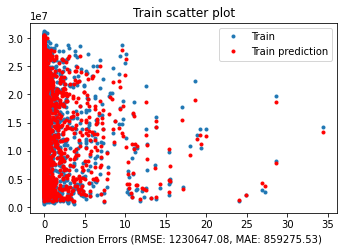

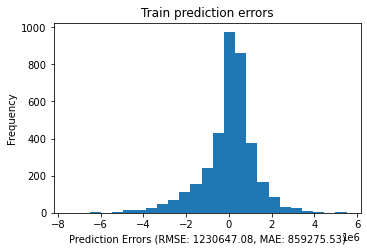

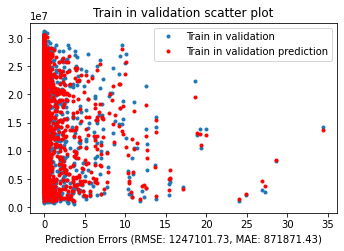

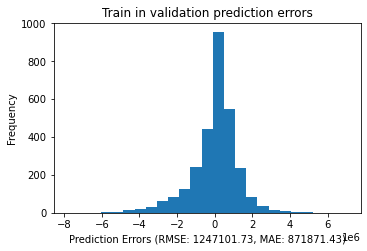

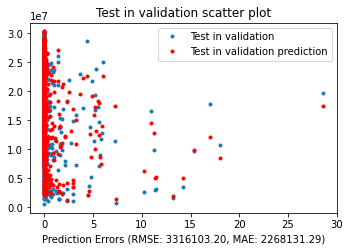

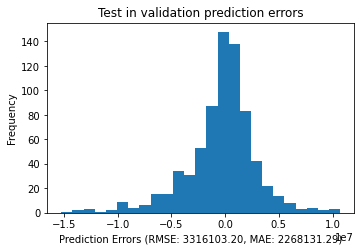

---------------------------------------------------
RANDOM FOREST PREDEFINED PARAMETERS best model is:

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('model',
                                        RandomForestRegressor(random_state=10))]),
             n_jobs=-1,
             param_grid={'model__criterion': ['squared_error'],
                         'model__max_depth': [None],
                         'model__max_features': [None],
                         'model__min_samples_split': [2],
                         'model__n_estimators': [100]},
             scoring='neg_mean_absolute_error')

Parameters: {'model__criterion': 'squared_error', 'model__max_depth': None, 'model__max_features': None, 'model__min_samples_split': 2, 'model__n_estimators': 100}

Performance: NMAE (val): -2453026.6184210526 | RMSE train: 1230647.077689153 | MAE train: 859275.5293150685 | RMSE train in validation: 1247101.733618

In [50]:
np.random.seed(10)
n_splits = 5

pipeline = Pipeline([("model", RandomForestRegressor(random_state=10))])

param_grid = {
    "model__n_estimators": [100],
    "model__criterion": ["squared_error"],
    "model__max_depth": [None],
    "model__min_samples_split": [2],
    "model__max_features": [None],
}

model = GridSearchCV(
    pipeline,
    param_grid,
    scoring="neg_mean_absolute_error",
    cv=TimeSeriesSplit(n_splits),
    n_jobs=-1,
)

start_time = time.time()
model.fit(X=X_train, y=y_train)
end_time = time.time()

total_time = end_time - start_time

# We calculate the subsets used for training and testing in the different folds of the cross-validation
# validation_splits(model, X_train)  # We al ready did the 5th fold split at the begginning

# We obtain the different scores of the model
score = train_validation_test(
    model,
    model.best_estimator_,
    model.best_score_,
    X_train,
    y_train,
)

models["RandForest_pred"] = model
results["RandForest_pred"] = score
times["RandForest_pred"] = total_time

print_results("RANDOM FOREST PREDEFINED PARAMETERS", model, score, total_time)

#### 7.2.1.2. Random Forests - Predefined parameters - Attribute selection

Results of the best estimator of Pipeline
NMAE in validation: -2453026.62
RMSE train: 1230647.08 | MAE train: 859275.53
RMSE validation train: 1246492.73 | MAE validation train: 872079.40
RMSE validation test: 3310640.67 | MAE validation test: 2264352.50


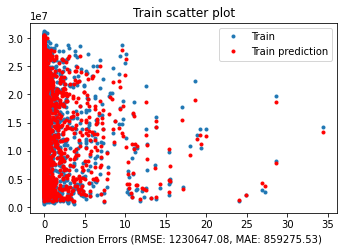

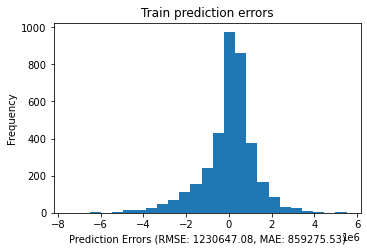

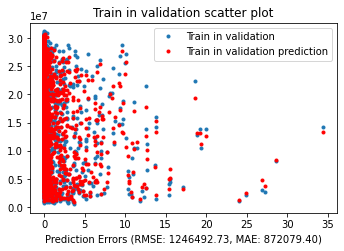

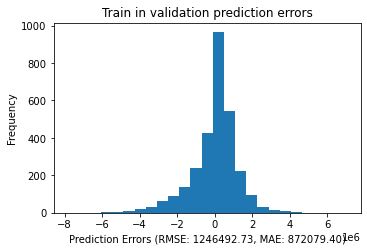

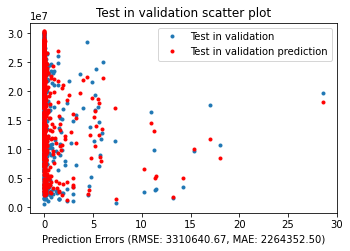

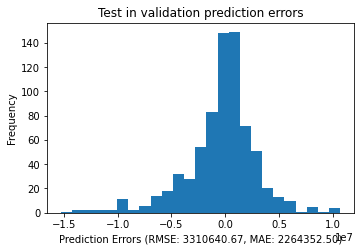

---------------------------------------------------
RANDOM FOREST PREDEFINED PARAMETERS best model is:

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('select',
                                        SelectKBest(score_func=<function f_regression at 0x0000022A9266B280>)),
                                       ('model',
                                        RandomForestRegressor(random_state=10))]),
             n_jobs=-1,
             param_grid={'model__criterion': ['squared_error'],
                         'model__max_depth': [None],
                         'model__max_features': [None],
                         'model__min_samples_split': [2],
                         'model__n_estimators': [100],
                         'select__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24,

In [51]:
np.random.seed(10)
n_splits = 5

pipeline = Pipeline(
    [("select", SelectKBest(f_regression)), ("model", RandomForestRegressor(random_state=10))]
)

param_grid = {
    "model__n_estimators": [100],
    "model__criterion": ["squared_error"],
    "model__max_depth": [None],
    "model__min_samples_split": [2],
    "model__max_features": [None],
    "select__k": list(range(1, X_train.shape[1] + 1)),
}

model = GridSearchCV(
    pipeline,
    param_grid,
    scoring="neg_mean_absolute_error",
    cv=TimeSeriesSplit(n_splits),
    n_jobs=-1,
)

start_time = time.time()
model.fit(X=X_train, y=y_train)
end_time = time.time()

total_time = end_time - start_time

# We calculate the subsets used for training and testing in the different folds of the cross-validation
# validation_splits(model, X_train)  # We al ready did the 5th fold split at the begginning

# We obtain the different scores of the model
score = train_validation_test(
    model,
    model.best_estimator_,
    model.best_score_,
    X_train,
    y_train,
)

models["RandForest_pred_k"] = model
results["RandForest_pred_k"] = score
times["RandForest_pred_k"] = total_time

print_results("RANDOM FOREST PREDEFINED PARAMETERS", model, score, total_time)

### 7.2.2. Random Forests - Selected parameters

Building upon the previous definition, we can reduce the most important parameters to be adjusted to the following:

- n_estimators: controls the number of trees in the forest.
- max_depth: controls the maximum depth of each tree in the forest.
- min_samples_split: controls the minimum number of instances a leaf must have in order to be able to subdivide. This parameter can prevent the tree from overfitting.
- min_samples_leaf: controls the minimum number of instances required to be at a leaf node. Like min_samples_split, this parameter can also help prevent overfitting.

#### 7.2.2.1. Random Forests - Selected parameters - No attribute selection

Results of the best estimator of Pipeline
NMAE in validation: -2378293.43
RMSE train: 1267395.22 | MAE train: 908598.93
RMSE validation train: 1215594.37 | MAE validation train: 850946.23
RMSE validation test: 3230903.24 | MAE validation test: 2197047.20


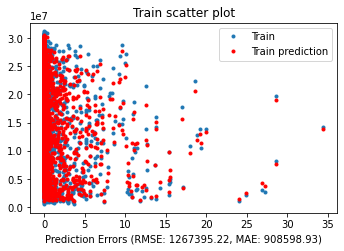

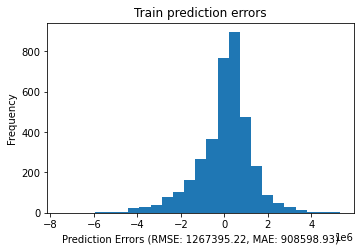

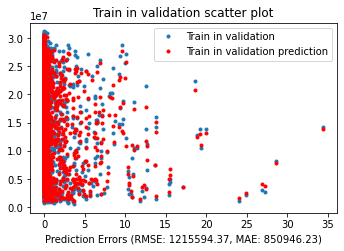

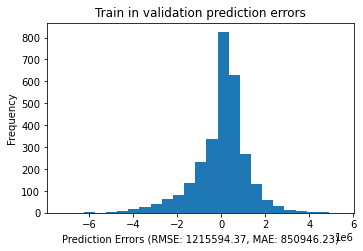

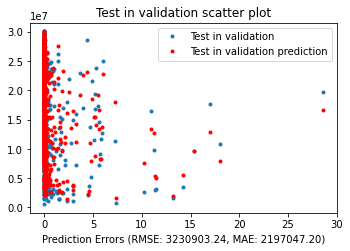

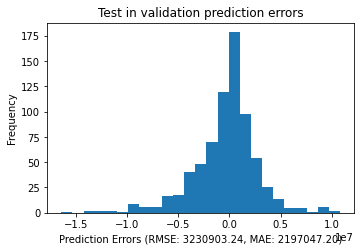

---------------------------------------------------
Random Forest best model is:

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('model',
                                              RandomForestRegressor(random_state=10))]),
                   n_iter=75, n_jobs=-1,
                   param_distributions={'model__max_depth': [5, 10, 15, 20, 25,
                                                             30, 35],
                                        'model__max_features': ['sqrt'],
                                        'model__min_samples_split': [2, 3, 4,
                                                                     5],
                                        'model__n_estimators': [100, 300, 350,
                                                                400, 450]},
                   scoring='neg_mean_absolute_error')

Parameters: {'model__n_estimators': 450, 'model__min_s

In [52]:
np.random.seed(10)
budget = 75
n_splits = 5

pipeline = Pipeline(
    [
        ("model", RandomForestRegressor(random_state=10))
    ]
)

param_grid = {
    "model__n_estimators": [100, 300, 350, 400, 450],
    "model__max_depth": list(range(5, 36, 5)),
    "model__min_samples_split": [2, 3, 4, 5],
    "model__max_features": ["sqrt"], # log2 does not offer as good results
}

model = RandomizedSearchCV(
    pipeline,
    param_grid,
    scoring="neg_mean_absolute_error",
    cv=TimeSeriesSplit(n_splits),
    n_iter=budget,
    n_jobs=-1,
)

start_time = time.time()
model.fit(X=X_train, y=y_train)
end_time = time.time()

total_time = end_time - start_time

# We calculate the subsets used for training and testing in the different folds of the cross-validation
# validation_splits(model, X_train)  # We al ready did the 5th fold split at the begginning

# We obtain the different scores of the model
score = train_validation_test(
    model,
    model.best_estimator_,
    model.best_score_,
    X_train,
    y_train,
)

models["RandForest_select"] = model
results["RandForest_select"] = score
times["RandForest_select"] = total_time

print_results("Random Forest", model, score, total_time)

In [53]:
rmse = []
mae = []
rmse2 = []
mae2 = []
rmse3 = []
mae3 =[]
[100, 300, 350, 400, 450]
for i in [100, 300, 350, 400, 450]: 
    model = RandomForestRegressor(random_state=10, n_estimators=i)
    model.fit(X_train_5th_fold_train , y_train_5th_fold_train )
    y_pred = model.predict(X_test_5th_fold_train)
    rmse3.append(np.sqrt(mean_squared_error(y_test_5th_fold_train , y_pred)))
    mae3.append(mean_absolute_error(y_test_5th_fold_train, y_pred))
    
for i in range(5, 36, 5): 
    model = RandomForestRegressor(random_state=10, max_depth=i)
    model.fit(X_train_5th_fold_train , y_train_5th_fold_train )
    y_pred = model.predict(X_test_5th_fold_train)
    rmse.append(np.sqrt(mean_squared_error(y_test_5th_fold_train , y_pred)))
    mae.append(mean_absolute_error(y_test_5th_fold_train, y_pred))
    
for i in range(5, 200):
    model = RandomForestRegressor(random_state=10, min_samples_split=i)
    model.fit(X_train_5th_fold_train , y_train_5th_fold_train )
    y_pred = model.predict(X_test_5th_fold_train)
    rmse2.append(np.sqrt(mean_squared_error(y_test_5th_fold_train , y_pred)))
    mae2.append(mean_absolute_error(y_test_5th_fold_train, y_pred))

# Crear dos subplots, uno para cada gráfico
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, figsize=(8, 12))

# Graficar RMSE vs. n_neighbors en el primer subplot
ax1.plot(list(range(5, 36, 5)), rmse, label="RMSE")
ax1.set_xlabel("max_depth")
ax1.set_ylabel("RMSE")
ax1.set_title("Gráfica de RMSE")

# Graficar MAE vs. n_neighbors en el segundo subplot
ax2.plot(list(range(5, 36, 5)), mae, label="MAE")
ax2.set_xlabel("max_depth")
ax2.set_ylabel("MAE")
ax2.set_title("Gráfica de MAE")

# Graficar RMSE vs. metric en el tercer subplot
ax3.plot([2, 3, 4, 5], rmse2, label="RMSE")
ax3.set_xlabel("min_samples_split")
ax3.set_ylabel("RMSE")
ax3.set_title("Gráfica de RMSE")

# Graficar MAE vs. metric en el cuarto subplot
ax4.plot([2, 3, 4, 5], mae2, label="MAE")
ax4.set_xlabel("min_samples_split")
ax4.set_ylabel("MAE")
ax4.set_title("Gráfica de MAE")

# Graficar RMSE vs. metric en el tercer subplot
ax5.plot([100, 300, 350, 400, 450], rmse3, label="RMSE")
ax5.set_xlabel("n_estimators")
ax5.set_ylabel("RMSE")
ax5.set_title("Gráfica de RMSE")

# Graficar MAE vs. metric en el cuarto subplot
ax6.plot([100, 300, 350, 400, 450], mae3, label="MAE")
ax6.set_xlabel("n_estimators")
ax6.set_ylabel("MAE")
ax6.set_title("Gráfica de MAE")


# Mostrar los gráficos
plt.show()

KeyboardInterrupt: 

#### 7.2.2.2. Random Forests - Selected parameters - Attribute selection

In [ ]:
np.random.seed(10)
n_splits = 5

pipeline = Pipeline(
    [("select", SelectKBest(f_regression)), ("model", RandomForestRegressor(random_state=10))]
)

param_grid = {
    "model__n_estimators": [400],
    "model__max_depth": [15],
    "model__min_samples_split": [2],
    "model__max_features": ["sqrt"],
    "select__k": list(range(1, X_train.shape[1] + 1)),
}

model = GridSearchCV(
    pipeline,
    param_grid,
    scoring="neg_mean_absolute_error",
    cv=TimeSeriesSplit(n_splits),
    n_jobs=-1,
)

start_time = time.time()
model.fit(X=X_train, y=y_train)
end_time = time.time()

total_time = end_time - start_time

# We calculate the subsets used for training and testing in the different folds of the cross-validation
# validation_splits(model, X_train)  # We al ready did the 5th fold split at the begginning

# We obtain the different scores of the model
score = train_validation_test(
    model,
    model.best_estimator_,
    model.best_score_,
    X_train,
    y_train,
)

models["RandForest_select_k"] = model
results["RandForest_select_k"] = score
times["RandForest_select_k"] = total_time

print_results("Random Forest", model, score, total_time)

KeyboardInterrupt: 

## 7.3. Attribute importance

In [ ]:
# Plotting the most used attributes
#get_variable_freq()

# Getting the importance of each attribute in the models
print("Random forest feature importance")
for model in models:
    # Only for Random Forest
    if model.startswith("RandForest"):
        
        # Get the feature importances and attribute names
        feature_importances = models[model].best_estimator_.named_steps["model"].feature_importances_
        #attribute_names = models[model].best_estimator_.named_steps["preprocessor"].transformers_[0][2]
        # Print the feature importance + the name of the attribute
        for feature_importance in feature_importances:
            print(f"{feature_importance}")

In [ ]:
# Sort feature importances in descending order
if model.startswith("RandForest"):
        print(model)
        # Get the feature importances and attribute names
        feature_importances = models[model].best_estimator_.named_steps["model"].feature_importances_
        
importances_descending = sorted(zip(feature_importances, disp_df.columns), reverse=True)
# Print top n attributes and their importances
n_top_attributes = 5
for importance, attribute_name in importances_descending[:n_top_attributes]:
    print(f"{attribute_name}: {importance}")


## 7.4. Conclusions

First of all, it must be understanded that the easiest way of knowing the most relevant attributes is by using the trees, since this model uses the attributes in ranked relevance to split data in each level. As we can see in the list provided, the most relevant attributes are the following: 
- dswrf_s4_1: 0.46959314797977664
- dswrf_s3_1: 0.19949434015634968
- uswrf_s4_1: 0.04859888546408619
- dswrf_s5_1: 0.04723173888571538
- uswrf_s3_1: 0.040436760096997794 
 
The meaning of this attributes can be found in the EDA section.

---
# 8. Best model
We will re-visit all the models and select the best one, which we have stated to be the one with the lowest MAE and the lowest RMSE.

In [ ]:
# ! Print the models best parameters
i = 0
for key, value in models.items():
    print(f"\n\n{i}. Sected model: {key}\n")
    print(f"Parameters: {value.best_params_}")
    print(
        f"\nPerformance:\n",
        f"NMAE (val): {results[key][0]}\n",
        f"RMSE train: {results[key][1]} | ",
        f"MAE train: {results[key][2]}\n",
        f"RMSE train in validation: {results[key][3]} | ",
        f"MAE train in validation: {results[key][4]}\n",
        f"RMSE test in validation: {results[key][5]} | ",
        f"MAE test in validation: {results[key][6]}",
        sep="",
    )
    print(f"Time: {times[key]} s")
    i+=1

plt.rcParams['figure.figsize'] = [10, 3.5]

# ! Plot (NMAE)
print("MODEL SCORES (NMAE in evaluation)")
iter = 0
for key, value in results.items():
    plt.bar(key, abs(value[0]))
    print(f"{iter}. {key}: {abs(value[0])}")
    iter += 1
plt.title("Score")
plt.xlabel("Model")
plt.ylabel("NMAE scoring in validation")
plt.tight_layout()

plt.xticks(rotation=45, ha='right', size=7)

# Exporting image as png to ../data/img folder
plt.savefig("../data/img/advanced_methods_score.png")
plt.show()

# ! Plot (MAE train in validation)
iter = 0
for key, value in results.items():
    plt.bar(key, abs(value[4]))
    print(f"{iter}. {key}: {abs(value[4])}")
    iter += 1
plt.title("Score")
plt.xlabel("Model")
plt.ylabel("MAE train in validation")
plt.tight_layout()

plt.xticks(rotation=45, ha='right', size=7)

# Exporting image as png to ../data/img folder
plt.savefig("../data/img/basic_methods_score.png")
plt.show()

# ! Plot (MAE test in validation)
iter = 0
for key, value in results.items():
    plt.bar(key, abs(value[6]))
    print(f"{iter}. {key}: {abs(value[6])}")
    iter += 1
plt.title("Score")
plt.xlabel("Model")
plt.ylabel("MAE test in validation")
plt.tight_layout()

plt.xticks(rotation=45, ha='right', size=7)

# Exporting image as png to ../data/img folder
plt.savefig("../data/img/basic_methods_score.png")
plt.show()

# ! Plot the time
iter = 0
for key, value in times.items():
    plt.bar(key, value)
    print(f"{iter}. {key}: {value}")
    iter += 1
plt.title("Time")
plt.xlabel("Model")
plt.ylabel("Time (s)")
plt.tight_layout()

plt.xticks(rotation=45, ha='right', size=7)

# Exporting image as png to ../data/img folder - easier to visualize the annotations, better resolution
plt.savefig("../data/img/basic_methods_time.png")
plt.show()

In [ ]:
get_variable_freq()

## 8.1. Best Model Selection

### 8.1.1. Best Model Prediction

In [ ]:
# The selected model is RandForest_select_k
sel_model = models["RandForest_select_k"]

# We calculate the subsets used for training and testing in the different folds of the cross-validation
# validation_splits(model, X_train)  # We al ready did the 5th fold split at the begginning

# We obtain the different scores of the model
score = train_validation_test(
    model,
    model.best_estimator_,
    model.best_score_,
    X_train,
    y_train,
)

NameError: name 'models' is not defined

We can see from the data displayed above that the two best models are Random Forest and SVM. Although SVM shows a slightly better NMAE score, we can also notice that Random Forest performs much better in terms of MAE and RMSE measurements.

Based on this data, we have decided to select Random Forest since it is more accurate when tested with the train and validation sets from the 5 validation folds. 

Note that SVM might improve significantly with an increase in C, but we have decided to limit it due to computation capabilities. This decision also provides a result with a balanced trade-off between time and scoring results

## 8.2. Selected Model Training - TODO

Once selected the best model, we will train in with all the data we have available, and then we will use it to predict the values of the competition dataset.

First, we divide the whole dataset into the training set (inputs, X, and outputs, y). Then, we train the model with the whole dataset, and to be predicted, the model should perform better than the one we selected first, as it has more training data.

In [ ]:
X_train = disp_df.drop("salida", axis=1)  # This is the input features for training
y_train = disp_df["salida"]  # This is the target variable for training

print("Data shape: ", disp_df.shape)
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)

In [ ]:
np.random.seed(10)
budget = 15
n_splits = 5

pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        # We scale the data to avoid overfitting - Recommended for SVMs
        ("model", SVR())
        # Support Vector Regression (SVR for regression, SVC for classification)
    ]
)

param_grid = {
    "model__kernel": ["linear", "poly", "rbf", "sigmoid"],
    "model__C": [100000, 500000, 1000000, 5000000],
    "model__gamma": ["scale", "auto"],
}

# We use TimeSeriesSplit to split the data in folds without losing the temporal order
model = RandomizedSearchCV(
    pipeline,
    param_grid,
    scoring="neg_mean_absolute_error",
    cv=TimeSeriesSplit(n_splits),
    n_iter=budget,
    n_jobs=-1,
)

start_time = time.time()
model.fit(X=X_train, y=y_train)
end_time = time.time()

total_time = end_time - start_time

# We calculate the subsets used for training and testing in the different folds of the cross-validation
# validation_splits(model, X_train)  # We al ready did the 5th fold split at the begginning

# We obtain the different scores of the model
score = train_validation_test(
    model,
    model.best_estimator_,
    model.best_score_,
    X_train,
    y_train,
)

models["SVM_select"] = model
results["SVM_select"] = score
times["SVM_select"] = total_time

print_results("SVM SELECTED PARAMETERS", model, score, total_time)

In [ ]:
# We will use the whole dataset to train the model - disp_df
np.random.seed(10)
budget = 100
n_splits = 5

pipeline = Pipeline(
    [
        ("select", SelectKBest(f_regression)),
        ("model", RandomForestRegressor(random_state=10))
    ]
)

param_grid = {
    "model__n_estimators": [100, 250, 300, 350, 400],
    "model__max_depth": list(range(5, 41, 5)),
    "model__min_samples_split": [2, 3, 4, 5, 6],
    "model__max_features": ["sqrt", "log2"],
    "select__k": list(range(1, X_train.shape[1], 5)),
}

model = RandomizedSearchCV(
    pipeline,
    param_grid,
    scoring="neg_mean_absolute_error",
    cv=TimeSeriesSplit(n_splits),
    n_iter=budget,
    n_jobs=-1,
)

start_time = time.time()
model.fit(X_train, y_train)
end_time = time.time()

total_time = end_time - start_time

# We calculate the subsets used for training and testing in the different folds of the cross-validation
# validation_splits(model, X_train)  # We al ready did the 5th fold split at the begginning

# We obtain the different scores of the model
score = train_validation_test(
    model,
    model.best_estimator_,
    model.best_score_,
    X_train,
    y_train,
)

models["final_model"] = model
results["final_model"] = score
times["final_model"] = total_time

print_results("Random Forest", model, score, total_time)

### 8.2.1. Selected Model Prediction and Comparison

The bad thing about using the whole dataset for training is that we don't have any data left for testing the model's performance. Without a separate set of data for testing, we cannot accurately evaluate how well the model generalizes to unseen data. 

To address this issue, we have implemented a function that calculates the Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) of the model on the fifth fold of the train-validation splits. This allows us to obtain an estimate of the model's performance on the most trained fold, which can serve as an indication of how well the model is likely to perform in the near future.

In [ ]:
plt.rcParams['figure.figsize'] = [10, 3.5]

print("MODEL SCORES (NMAE in evaluation)")
iter = 0
for key, value in results.items():
    plt.bar(key, abs(value[0]))
    print(f"{iter}. {key}: {abs(value[0])}")
    iter += 1
plt.title("Score")
plt.xlabel("Model")
plt.ylabel("NMAE scoring in validation")
plt.tight_layout()

plt.xticks(rotation=45, ha='right', size=7)

# Exporting image as png to ../data/img folder
plt.savefig("../data/img/best_methods_score.png")
plt.show()

## 8.3. Selected Model Export

In [ ]:
import pickle

selected_model = models["final_model"]

print(f"\nSelected model: {selected_model}, {type(selected_model)}, {selected_model.best_params_}")

# Export model as pickle file in ../data/model folder
with open("../data/model/modelo_final.pkl", "wb") as file:
    pickle.dump(selected_model, file)

# ! Compare the model exported with the one loaded - check if it is the same
# Load model from pickle file
with open("../data/model/modelo_final.pkl", "rb") as file:
    loaded_model = pickle.load(file)

print(f"\nSaved model: {loaded_model}, {type(loaded_model)}, {loaded_model.best_params_}")
    
if selected_model.best_params_ == loaded_model.best_params_:
    print("\n\nThe models has been saved and loaded correctly")
else:
    print("\n\nERROR: The models are different")

---
# 9. Final Conclusions

During this project, we have had the opportunity to gain a deeper understanding of the model selection process. We began with exploratory data analysis (EDA), which helped us to improve our understanding and management of the data. We found this to be an extremely useful tool throughout the entire project. We believe that this part of the project should be evaluated with greater emphasis, as it is the foundation upon which all of our decisions were based.

Next, we created and trained all of our models, gaining experience in the use of pipelines and a deeper understanding of the importance of hyperparameters. Finally, we analyzed the different results provided by each model, gaining a better understanding of their respective advantages and disadvantages in terms of scoring and time.

We believe that this project is an excellent complement to the main lessons, as it provides a deeper understanding of the subject matter.

---
# X. Output the Jupyter Notebook as an HTML file

In [ ]:
import os

# Export the notebook to HTML
os.system("jupyter nbconvert --to html model.ipynb --output ../data/html/model.html")
print("Notebook exported to HTML")